In [73]:
import fulu
import pandas as pd
from fulu import single_layer_aug
import numpy as np
from sklearn.model_selection import train_test_split
import aug_standart_ztf
import utils
from importlib import reload
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
import gp_aug
from gp_aug import bootstrap_estimate_mean_stddev

In [74]:
diff_between_format_bts_and_mjd = 2458000 - 2400000.5
N_OBS = 2000
path = '/home/masha/AstroAugumetation/'
path_to = "/home/masha/AstroAugumetation/ZTF_BTS_02_02__02_04_2021.csv"
color = {1: 'red', 0: 'green'}
passband2lam  = {0: 1, 1: 2} # green, red 

calculate_mjd = lambda x: x + diff_between_format_bts_and_mjd


bts = pd.read_csv(path_to, sep =',')
bts = bts.drop('Unnamed: 0', 1) 

df_all = pd.read_csv(path + 'ANTARES.csv')
df_all = df_all.drop('Unnamed: 0', 1)

print("Названия колонок в таблице ANTARES.csv со всеми кривыми блеска: \n\n", df_all.columns, "\n\n")
print("Количество объектов: ", len(df_all['object_id'].unique()))

obj_names = df_all['object_id'].unique()
df_all.loc[df_all.obj_type == 'SN Ia', 'obj_type'] = 1
df_all.loc[df_all.obj_type != 1, 'obj_type'] = 0

Названия колонок в таблице ANTARES.csv со всеми кривыми блеска: 

 Index(['object_id', 'mjd', 'passband', 'flux', 'flux_err', 'obj_type',
       'peak_time'],
      dtype='object') 


Количество объектов:  1403


In [75]:
df_all[:3]

object_id           mjd  passband       flux  flux_err obj_type  \
0  ZTF18aajpjdi  58242.252847         1  14.157950  0.425610        1   
1  ZTF18aajpjdi  58245.207500         1  14.925189  2.228412        1   
2  ZTF18aajpjdi  58248.252627         1  10.866266  0.507728        1   

   peak_time  
0   58245.21  
1   58245.21  
2   58245.21

In [76]:
# train/test split data
anobject = aug_standart_ztf.get_object(df_all, 'ZTF18aajpjdi')
anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)

In [77]:
model = single_layer_aug.SingleLayerNetAugmentation(passband2lam)

RMSE:  2.756880568143905
MAE:  2.4005852595733104
RSE:  1.033035333320292
RAE:  1.0296498457411463
MAPE:  53.647120084028096


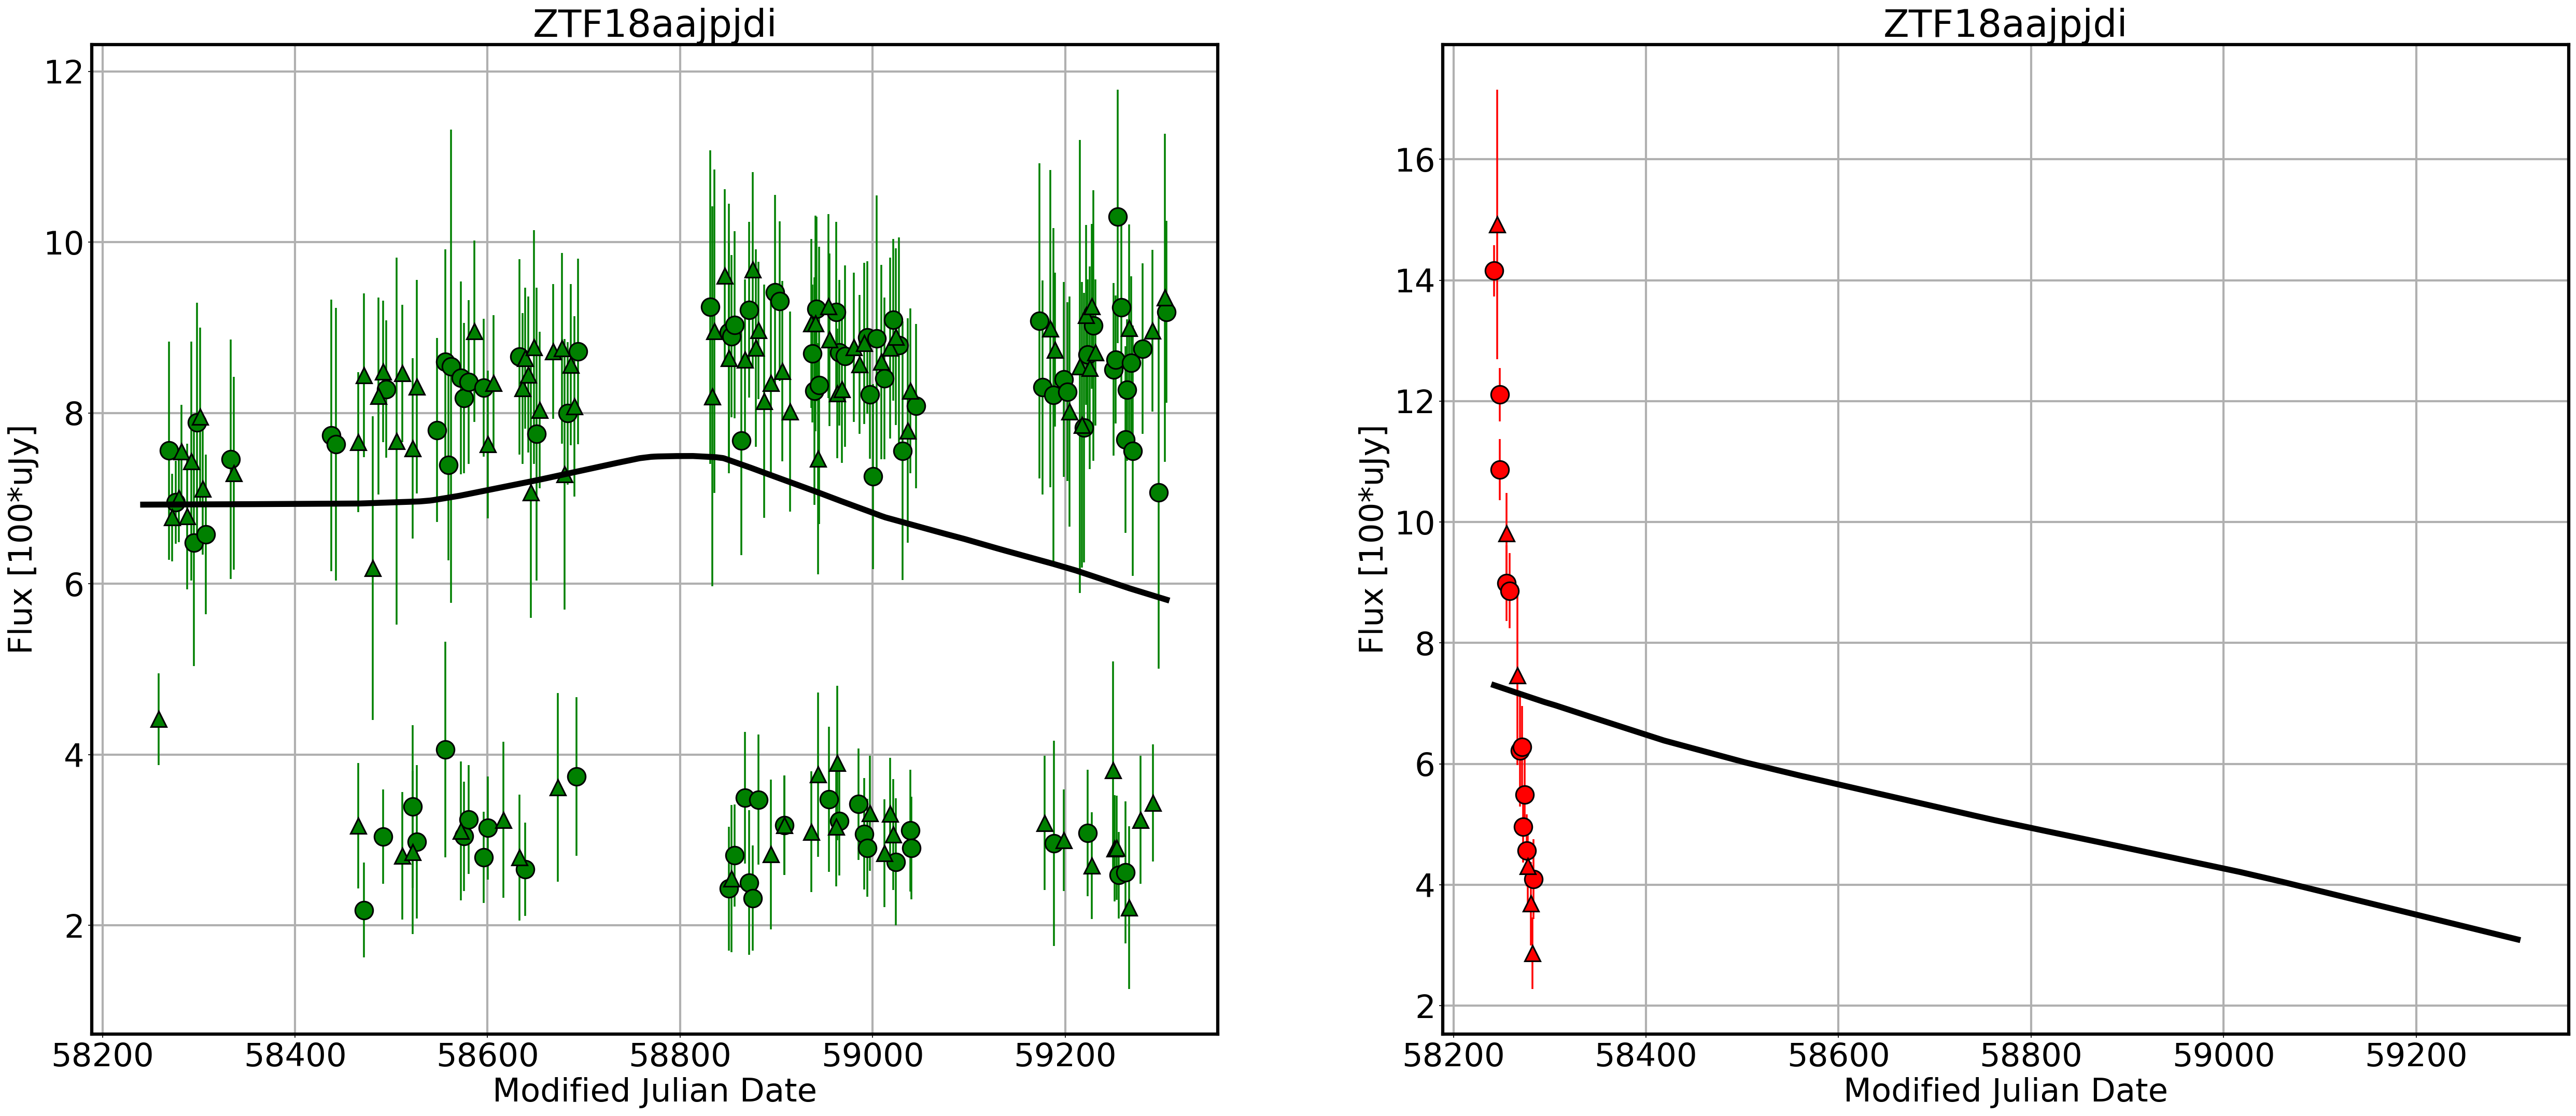

In [78]:
# fit augmentation model
model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
          anobject_train['flux_err'].values, anobject_train['passband'].values)

# predict flux for unseen observations
flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values)

# augmentation
t_aug, flux_aug, flux_err_aug, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                                  anobject['mjd'].max(), 
                                                                  n_obs=N_OBS)
anobject_test_pred = anobject_test.copy()
anobject_test_pred['flux'], anobject_test_pred['flux_err'] = flux_pred, flux_err_pred

# calculate quality metrics
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                      anobject_test_pred['flux'])
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)

# visualize augmented light curve
fig = plt.figure(figsize=(35,35), dpi = 150)
plt.rcParams.update({'font.size': 30})
fig.subplots_adjust(left=0.07, right=0.98, top=0.95, bottom=0.15)
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)

ax1.spines['bottom'].set_linewidth(3)
ax1.spines['top'].set_linewidth(3)
ax1.spines['left'].set_linewidth(3)
ax1.spines['right'].set_linewidth(3)
    
ax2.spines['bottom'].set_linewidth(3)
ax2.spines['top'].set_linewidth(3)
ax2.spines['left'].set_linewidth(3)
ax2.spines['right'].set_linewidth(3)

anobject_aug = aug_standart_ztf.compile_obj(t_aug, flux_aug, flux_err_aug, passbands_aug)

aug_standart_ztf.plot_light_curves_ax_band(anobject_test, anobject_train, \
                                           anobject_aug, ax1, ax2, 'ZTF18aajpjdi')

report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])

In [79]:
reload(aug_standart_ztf)
reload(gp_aug)
from gp_aug import bootstrap_estimate_mean_stddev

15it [00:13,  1.15it/s]


Среднее значение метрики RMSE 4.264820596111589 +- 0.9349397341866269
Среднее значение метрики MAE 2.9843318752766956 +- 0.6775286429914649
Среднее значение метрики RSE 0.44488191898114127 +- 0.048888799109580605
Среднее значение метрики RAE 0.3772690565112245 +- 0.05186937555722788
Среднее значение метрики MAPE 30.269238928771625 +- 6.088191613293011


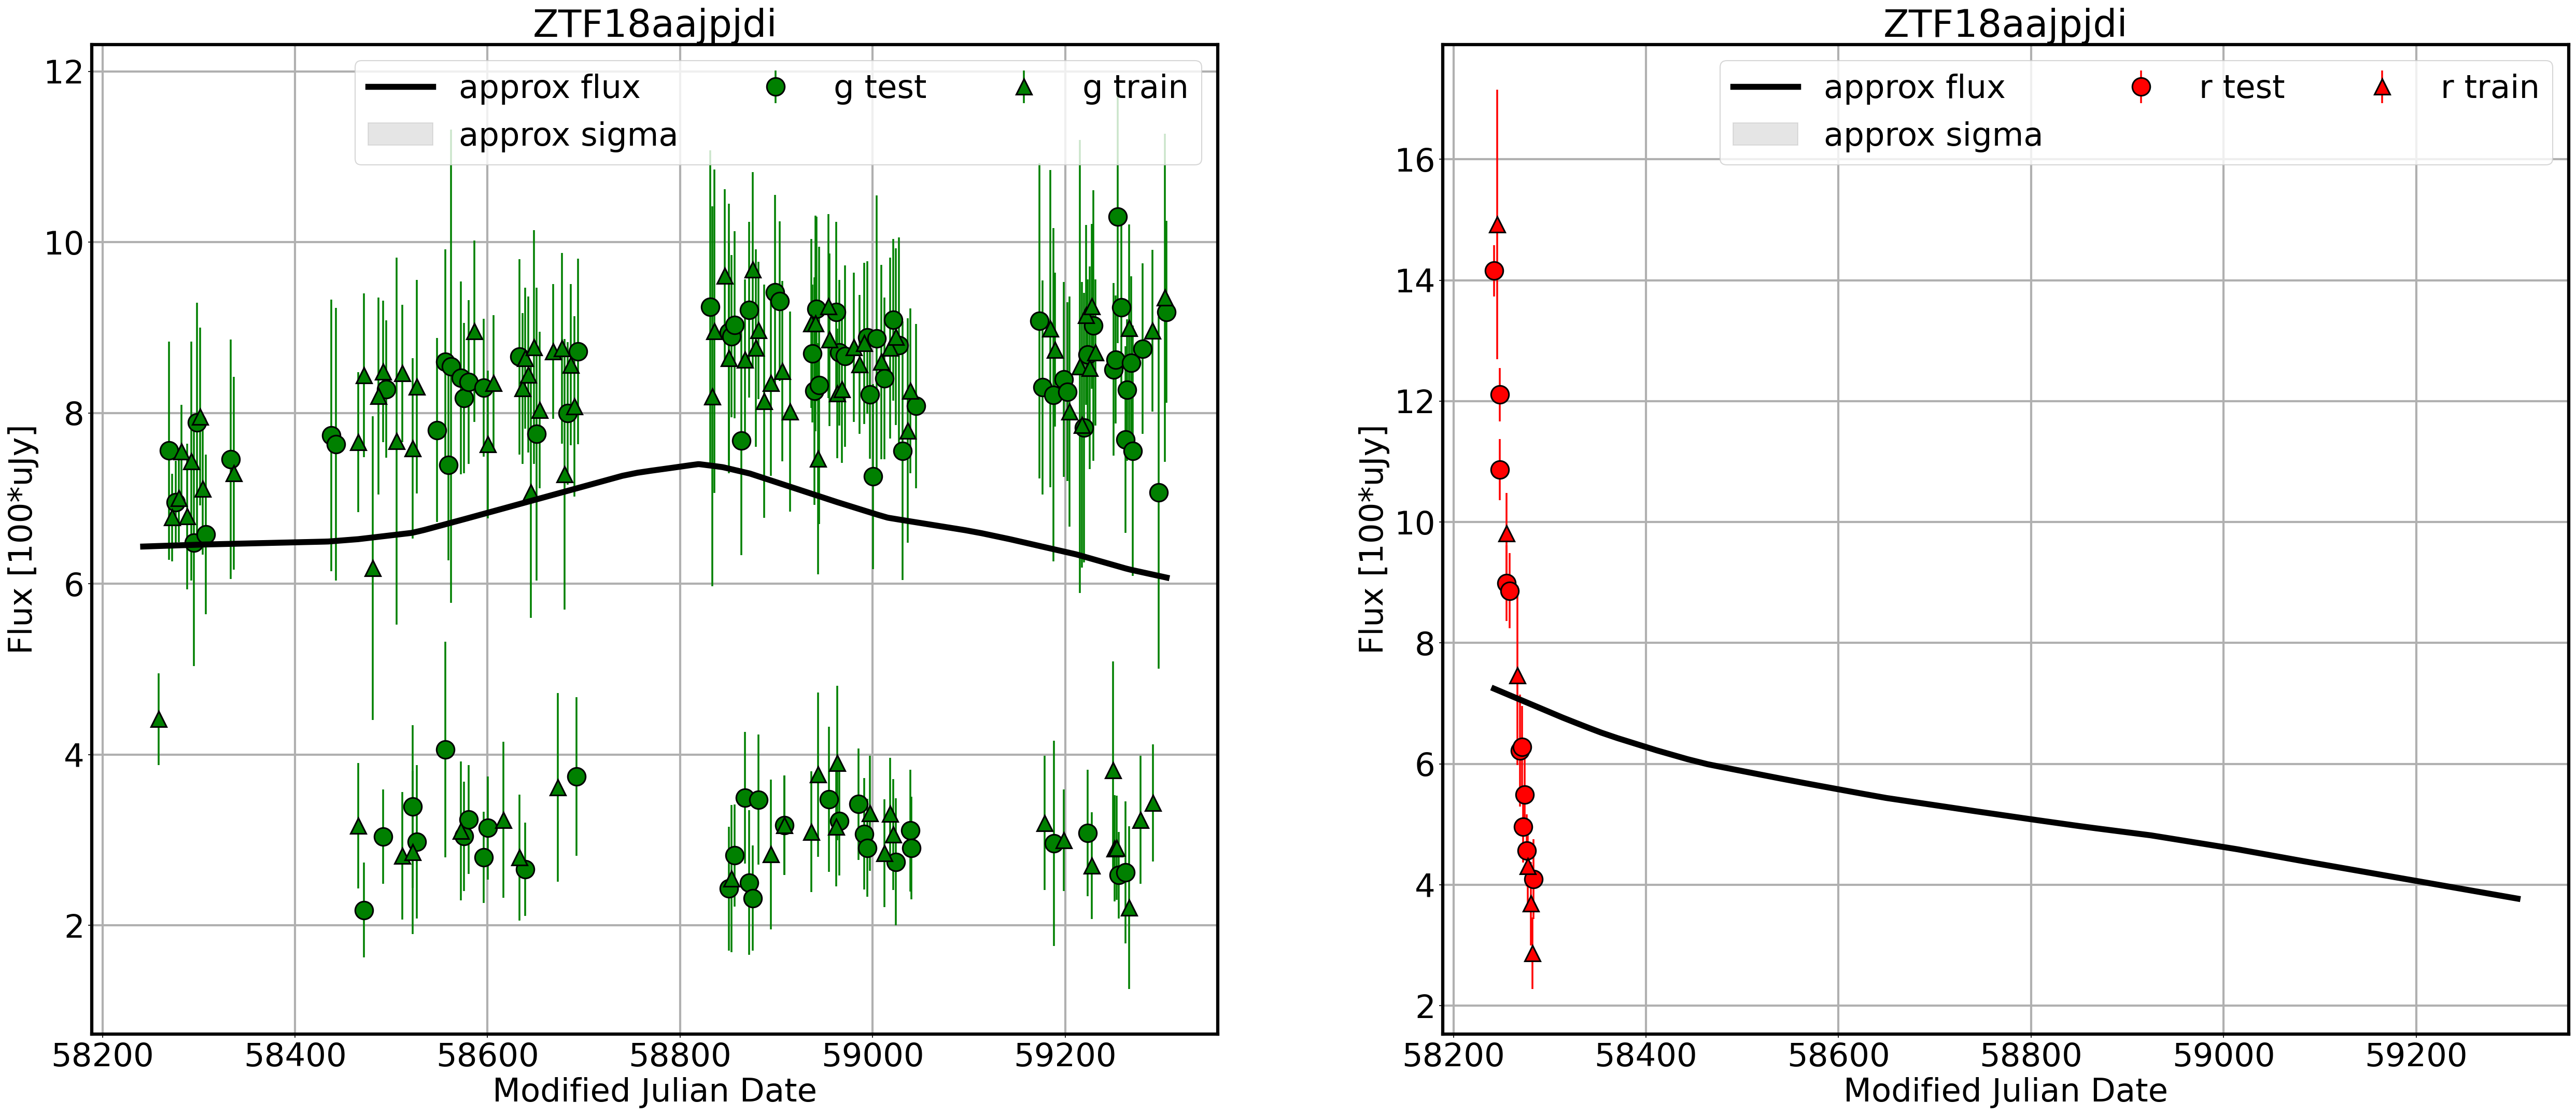

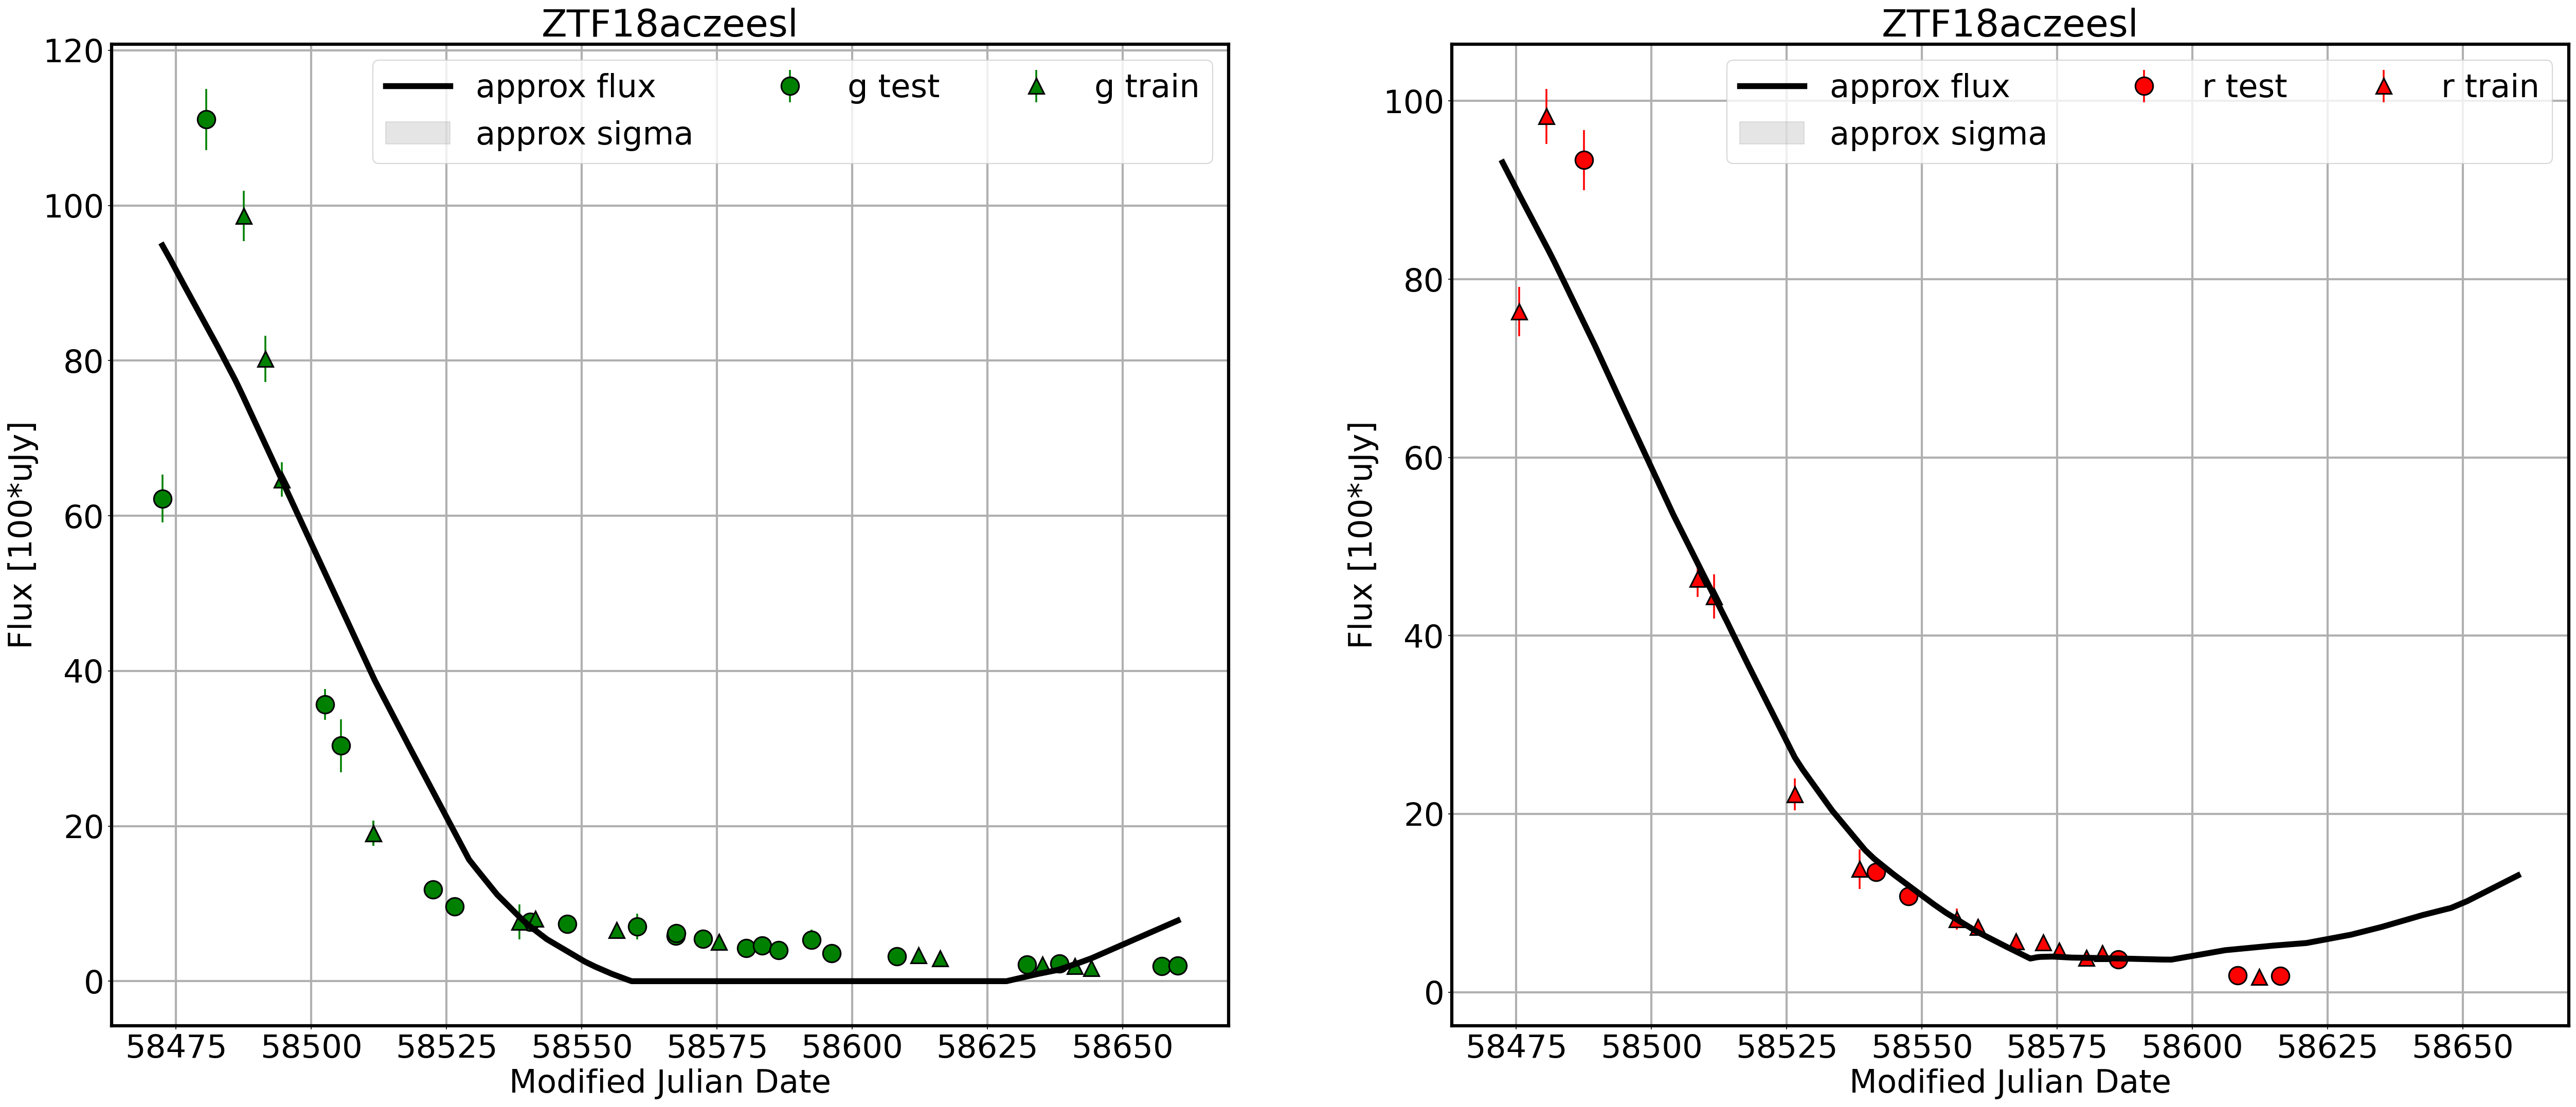

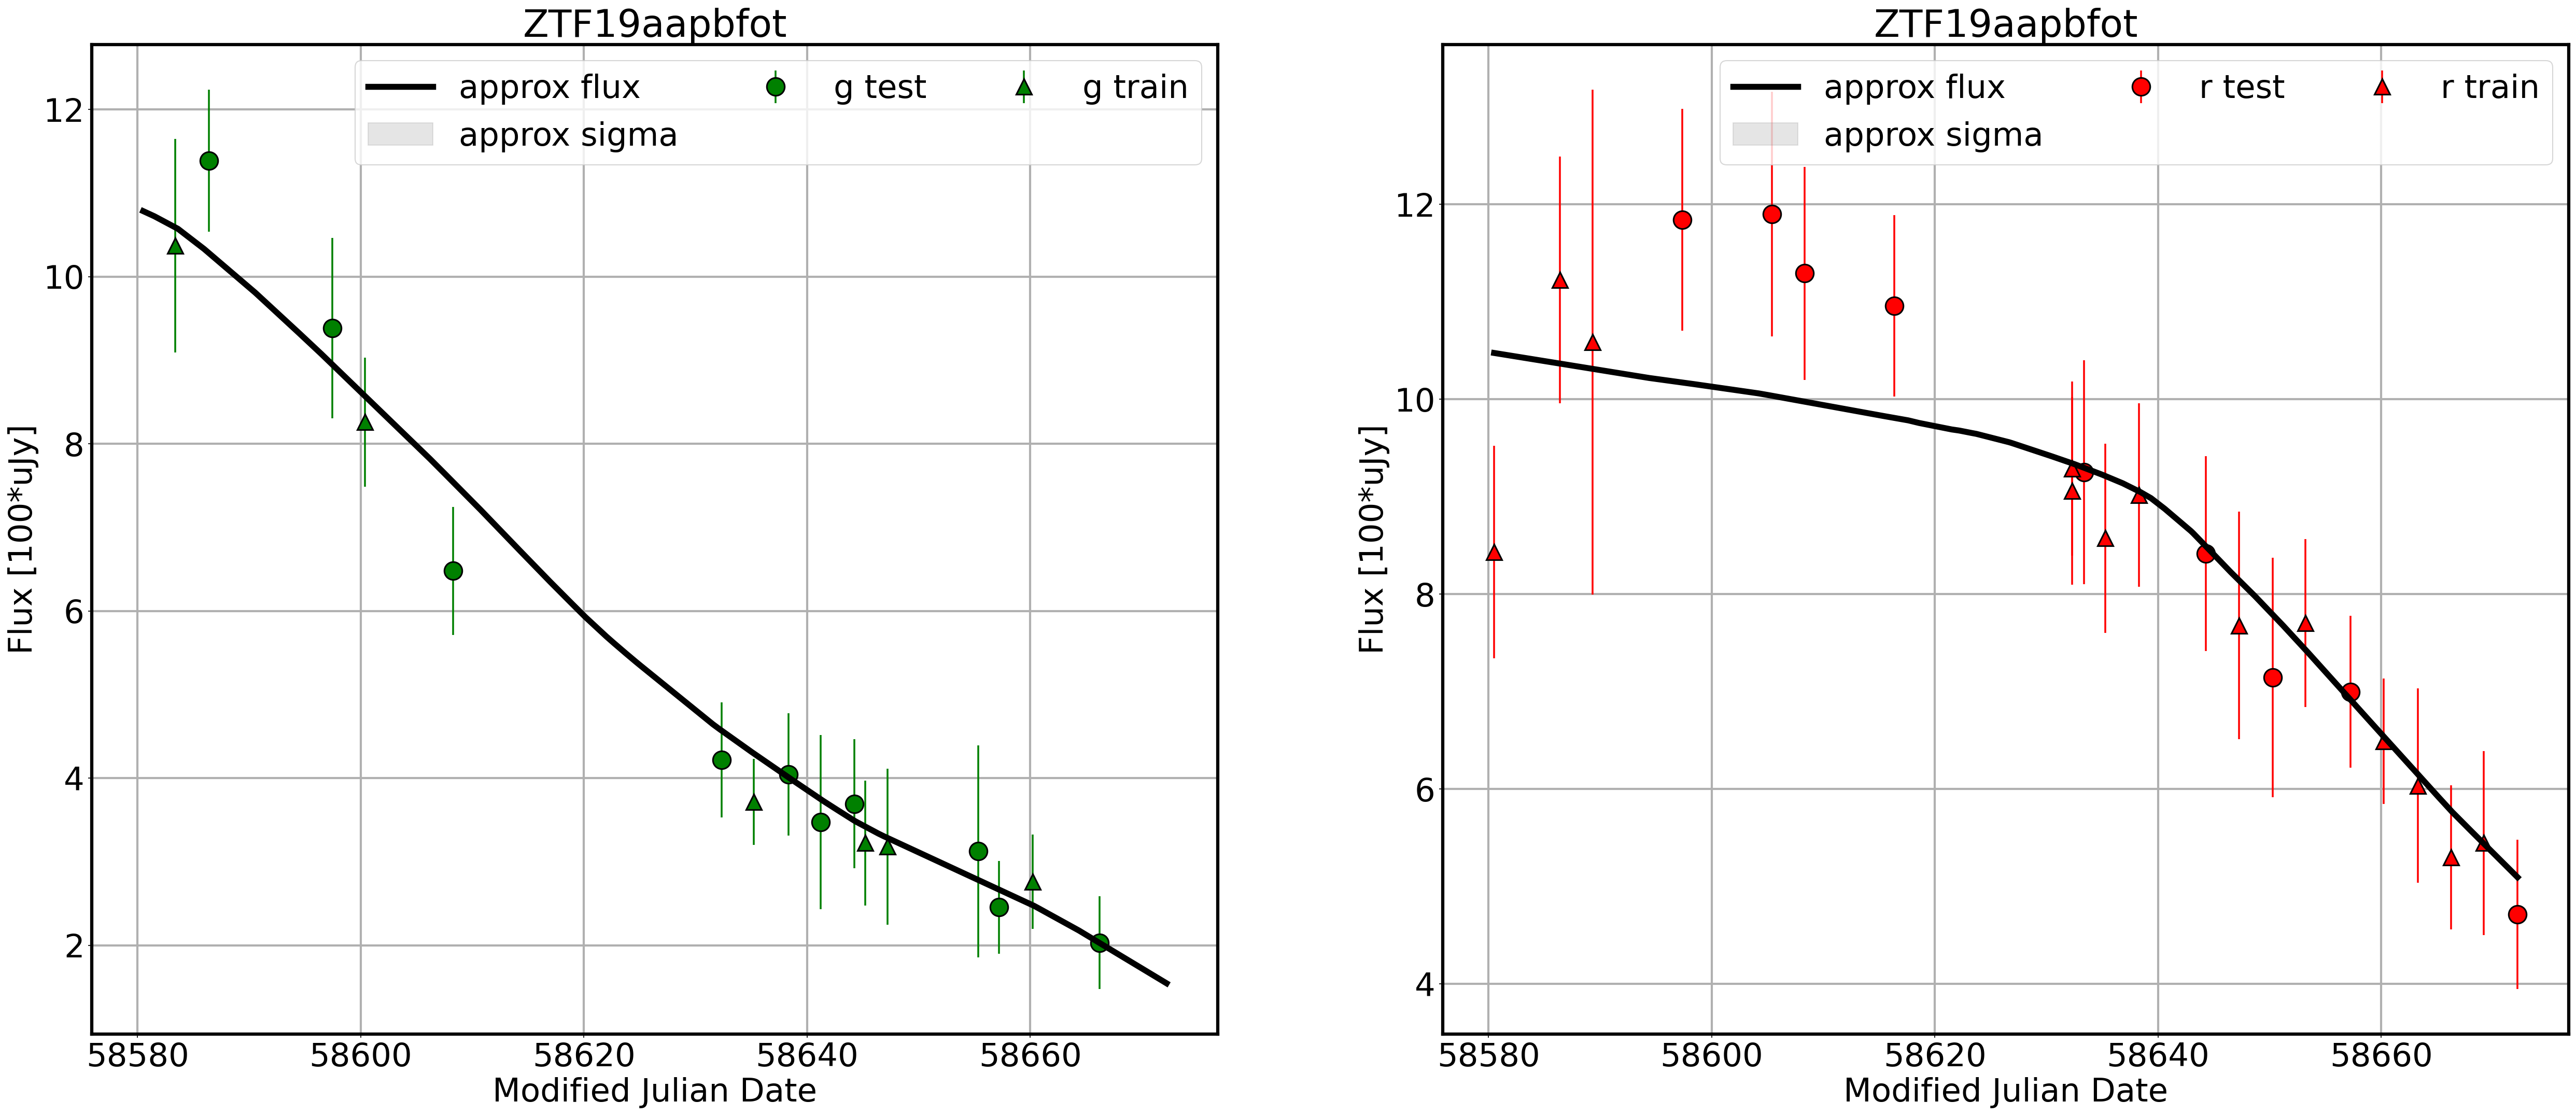

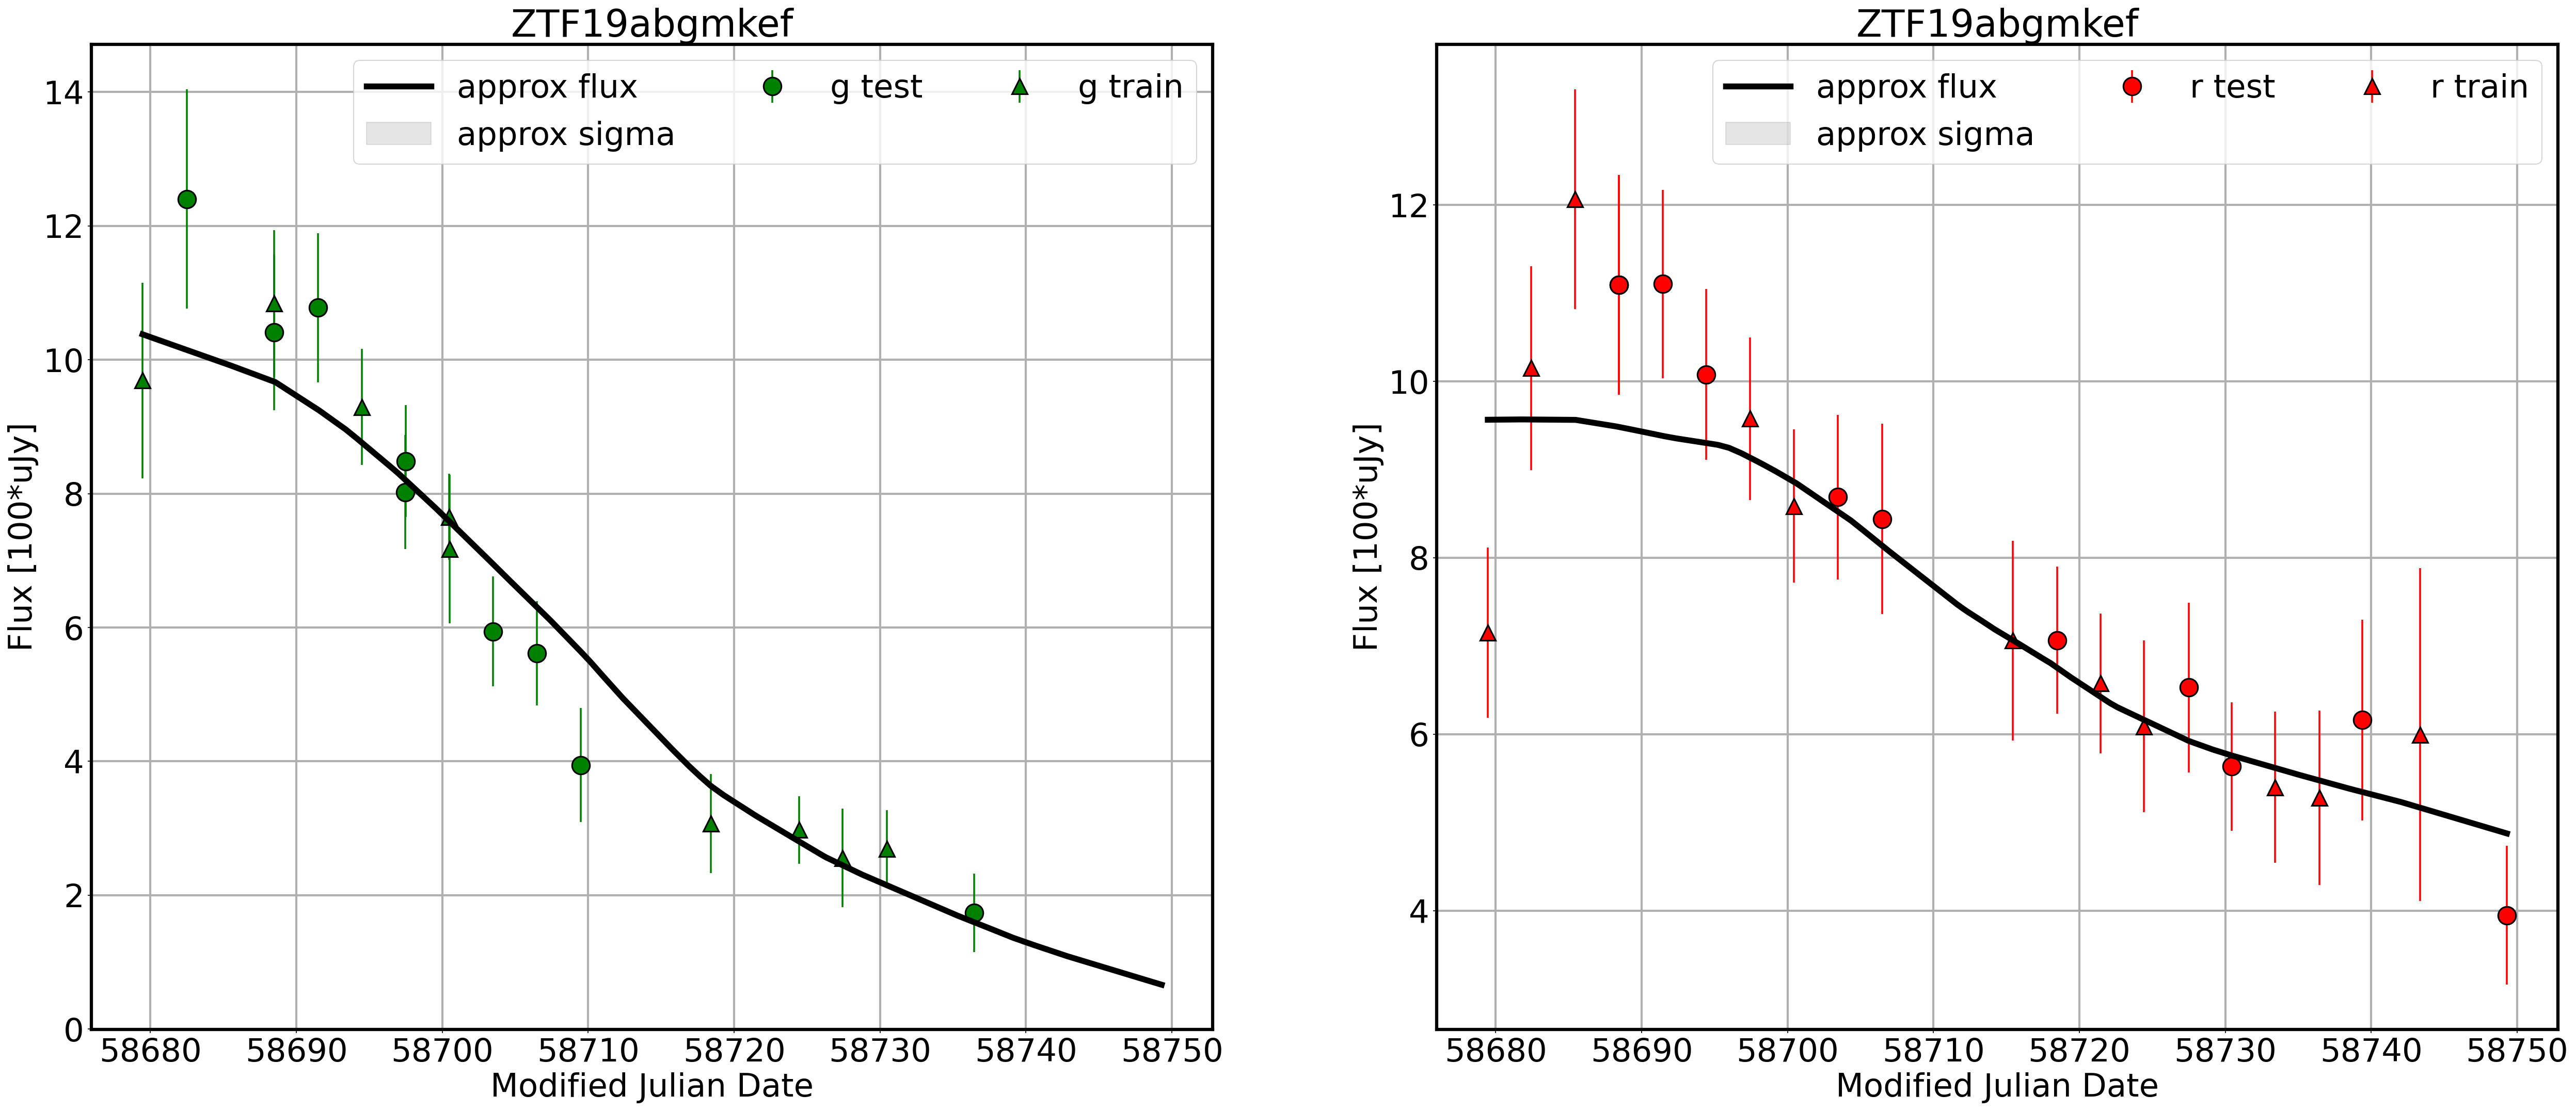

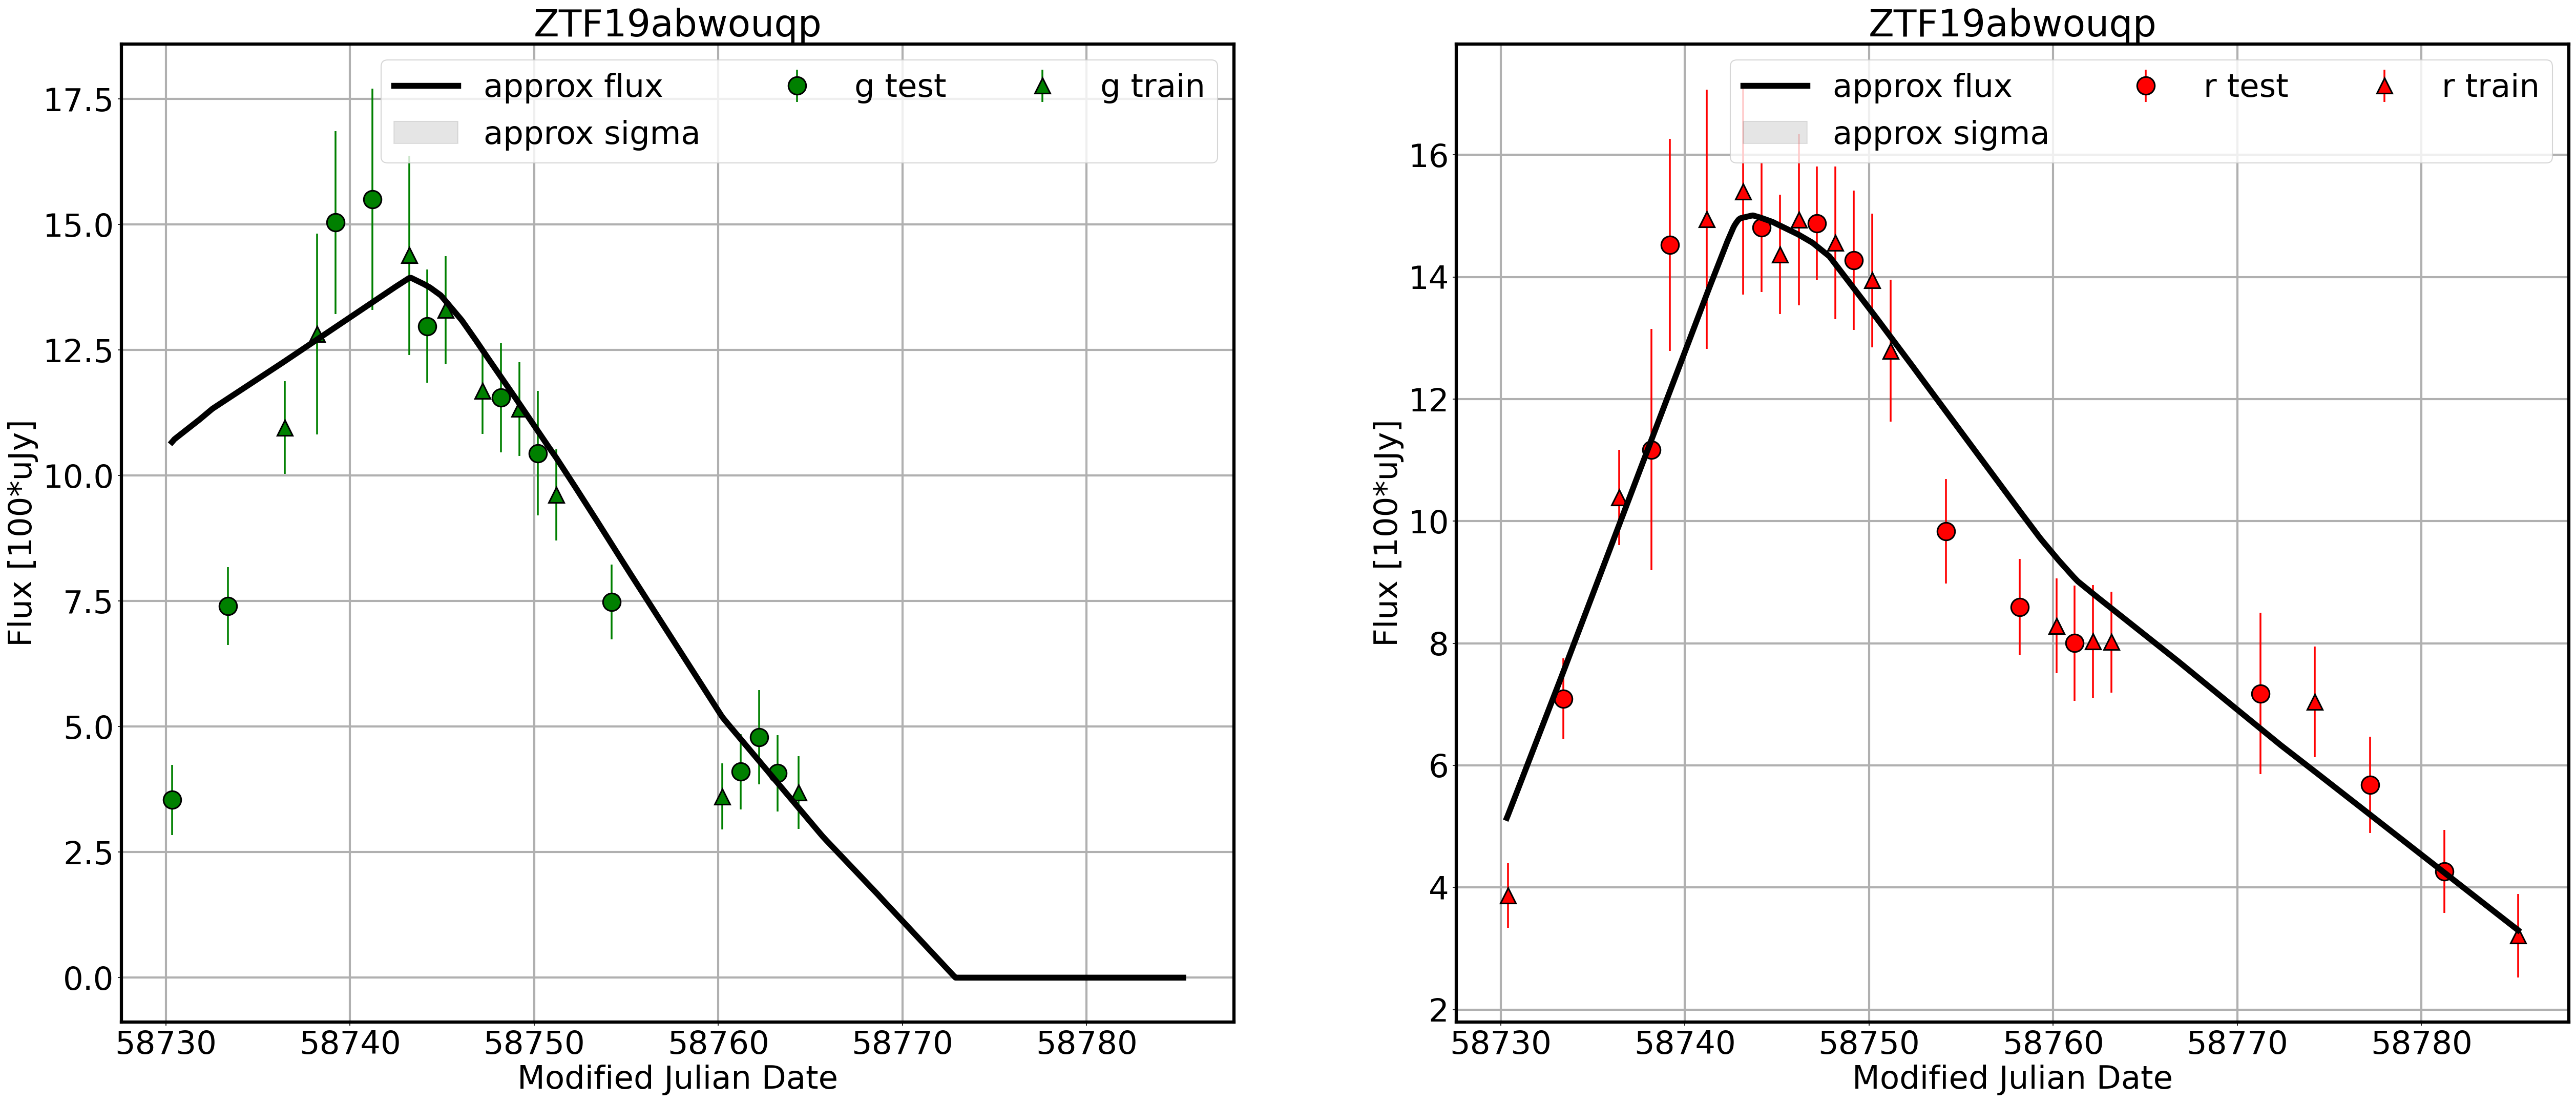

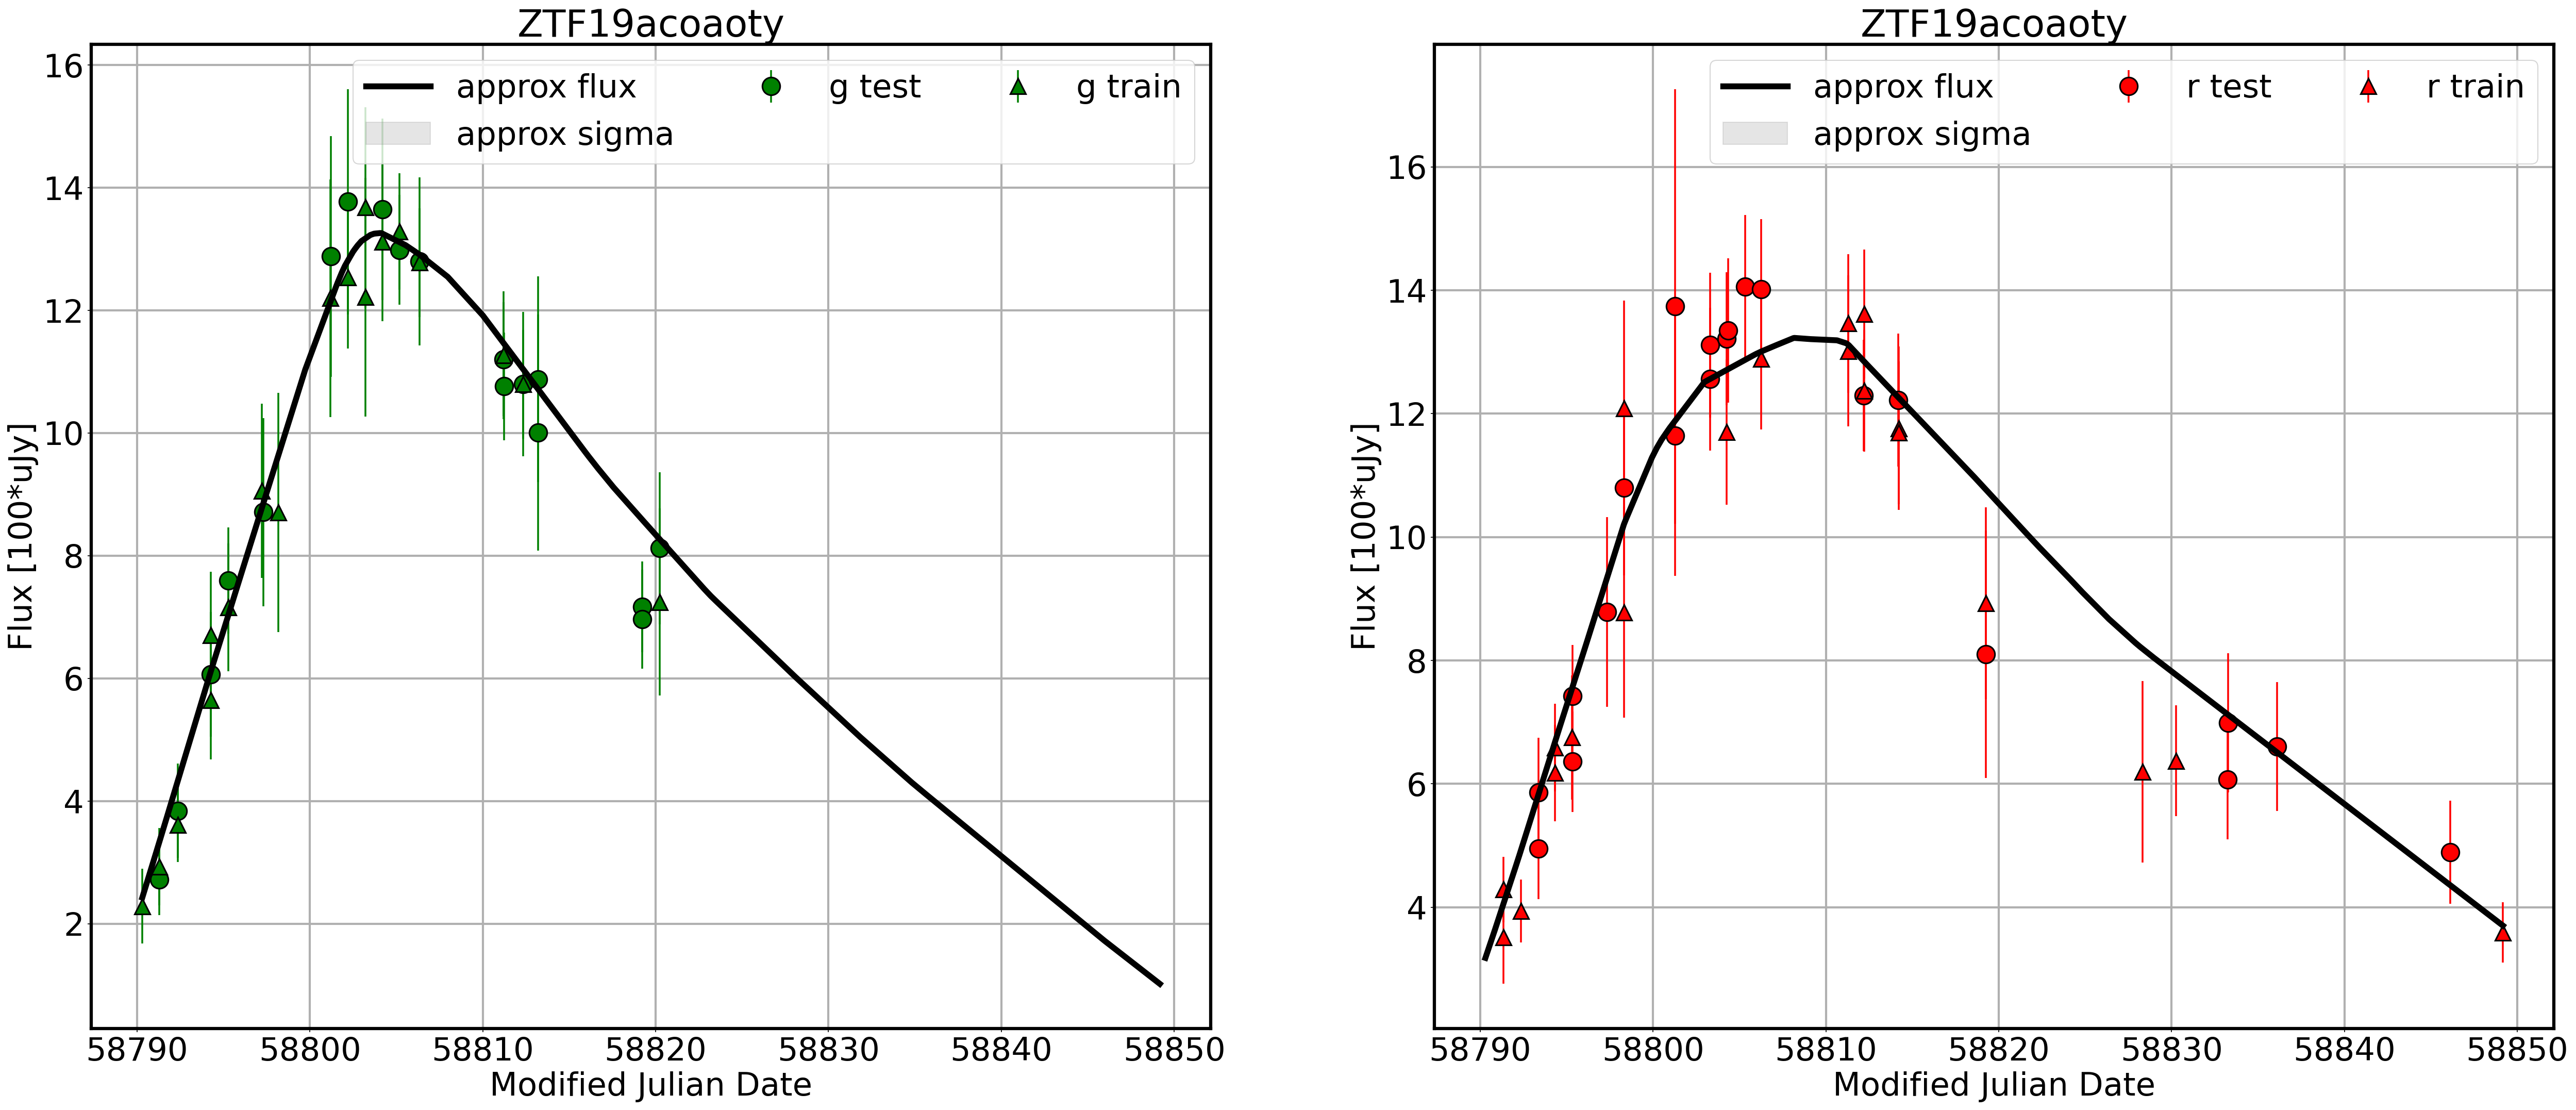

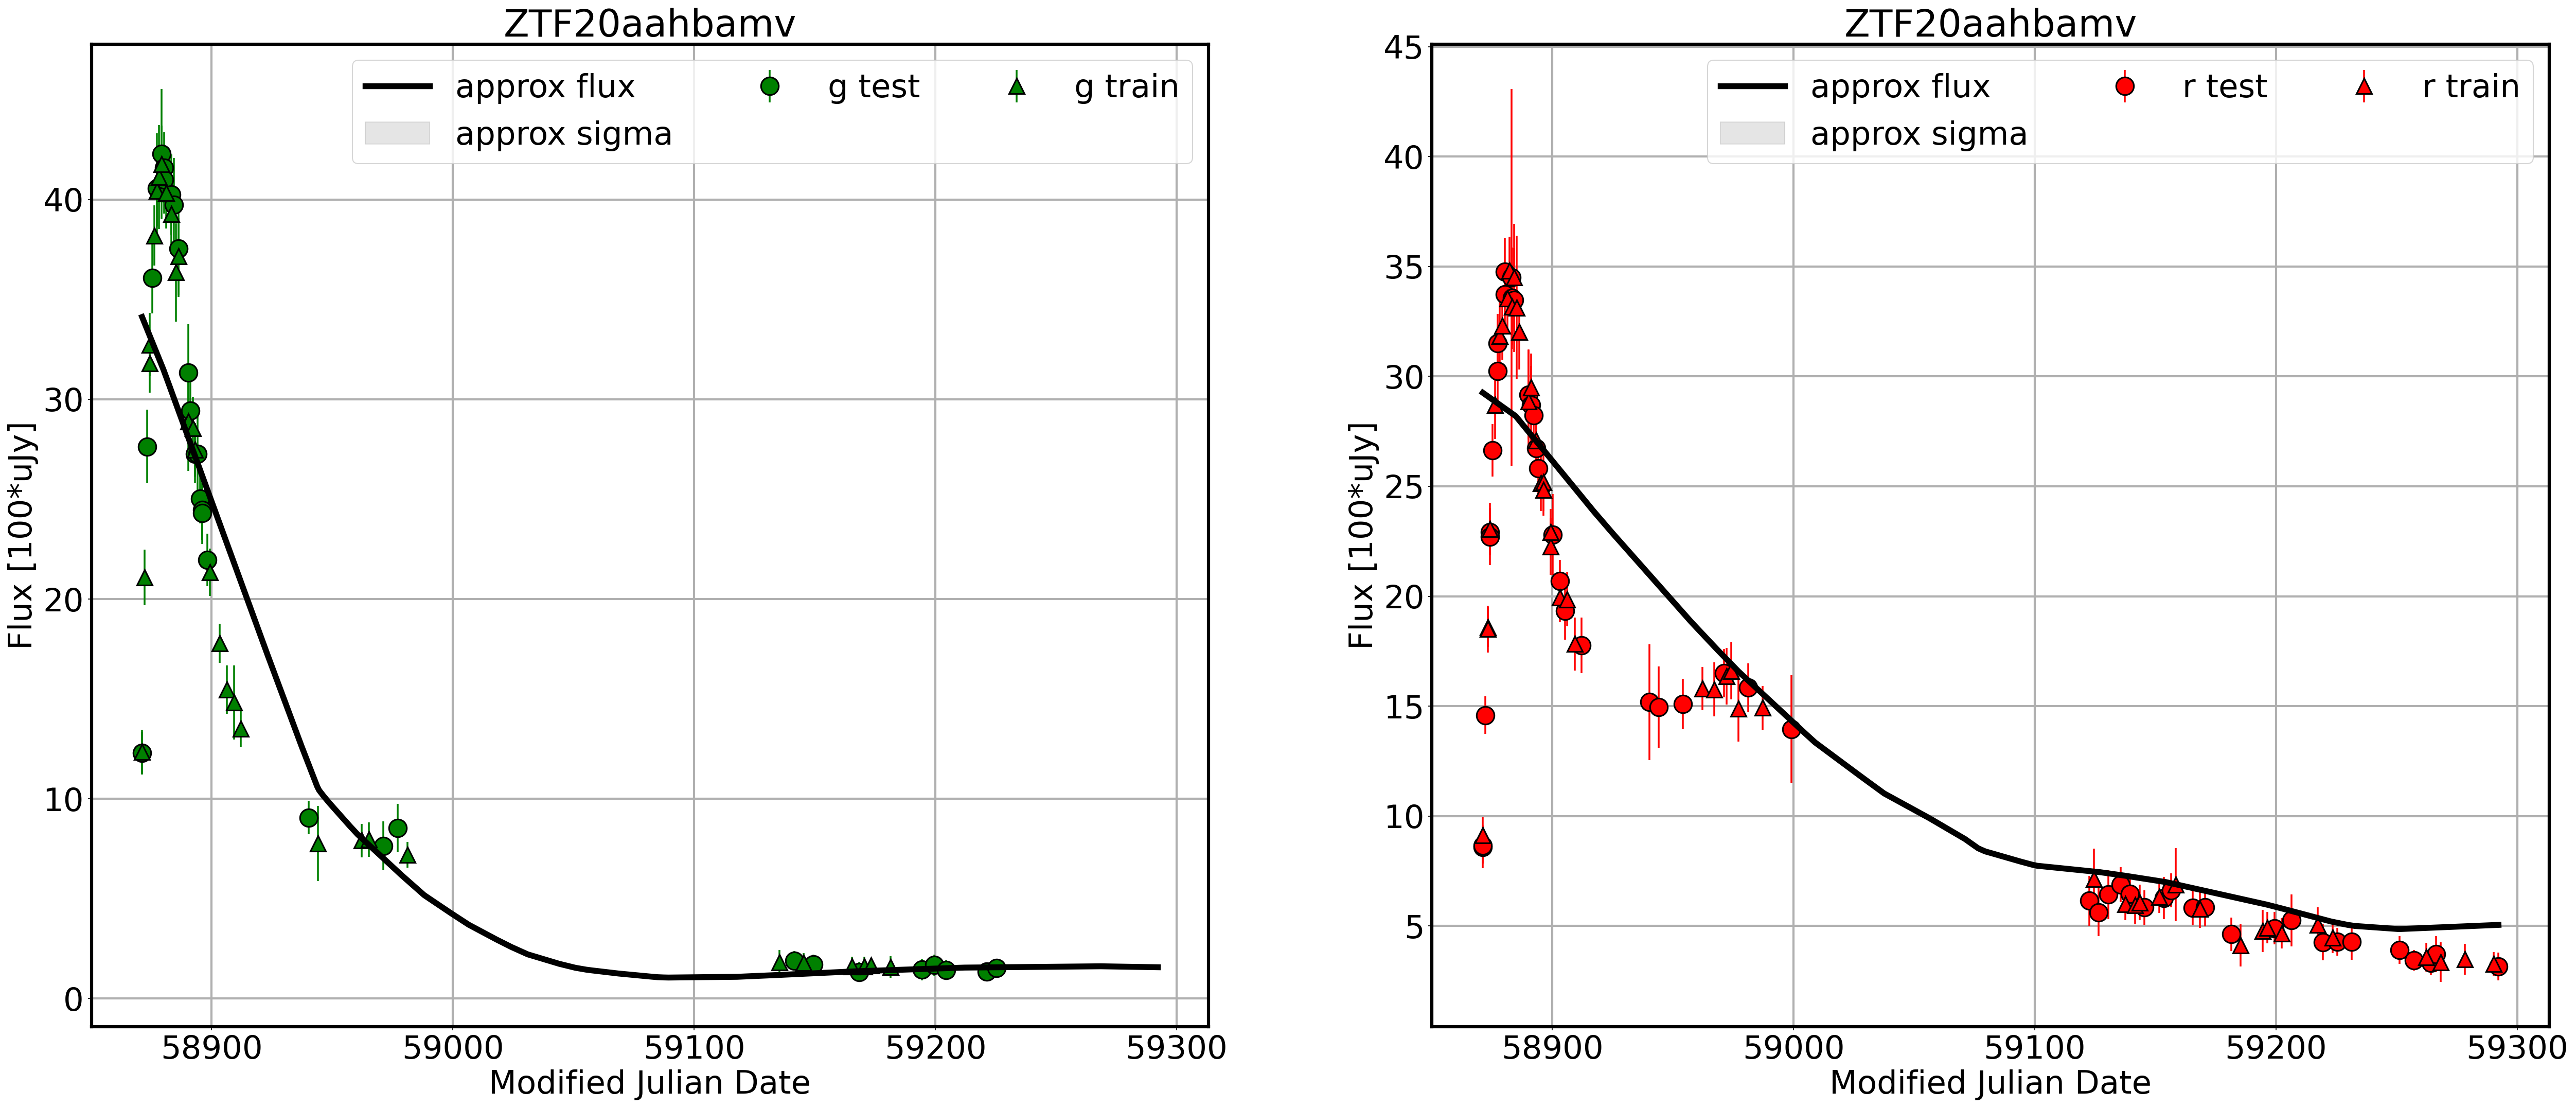

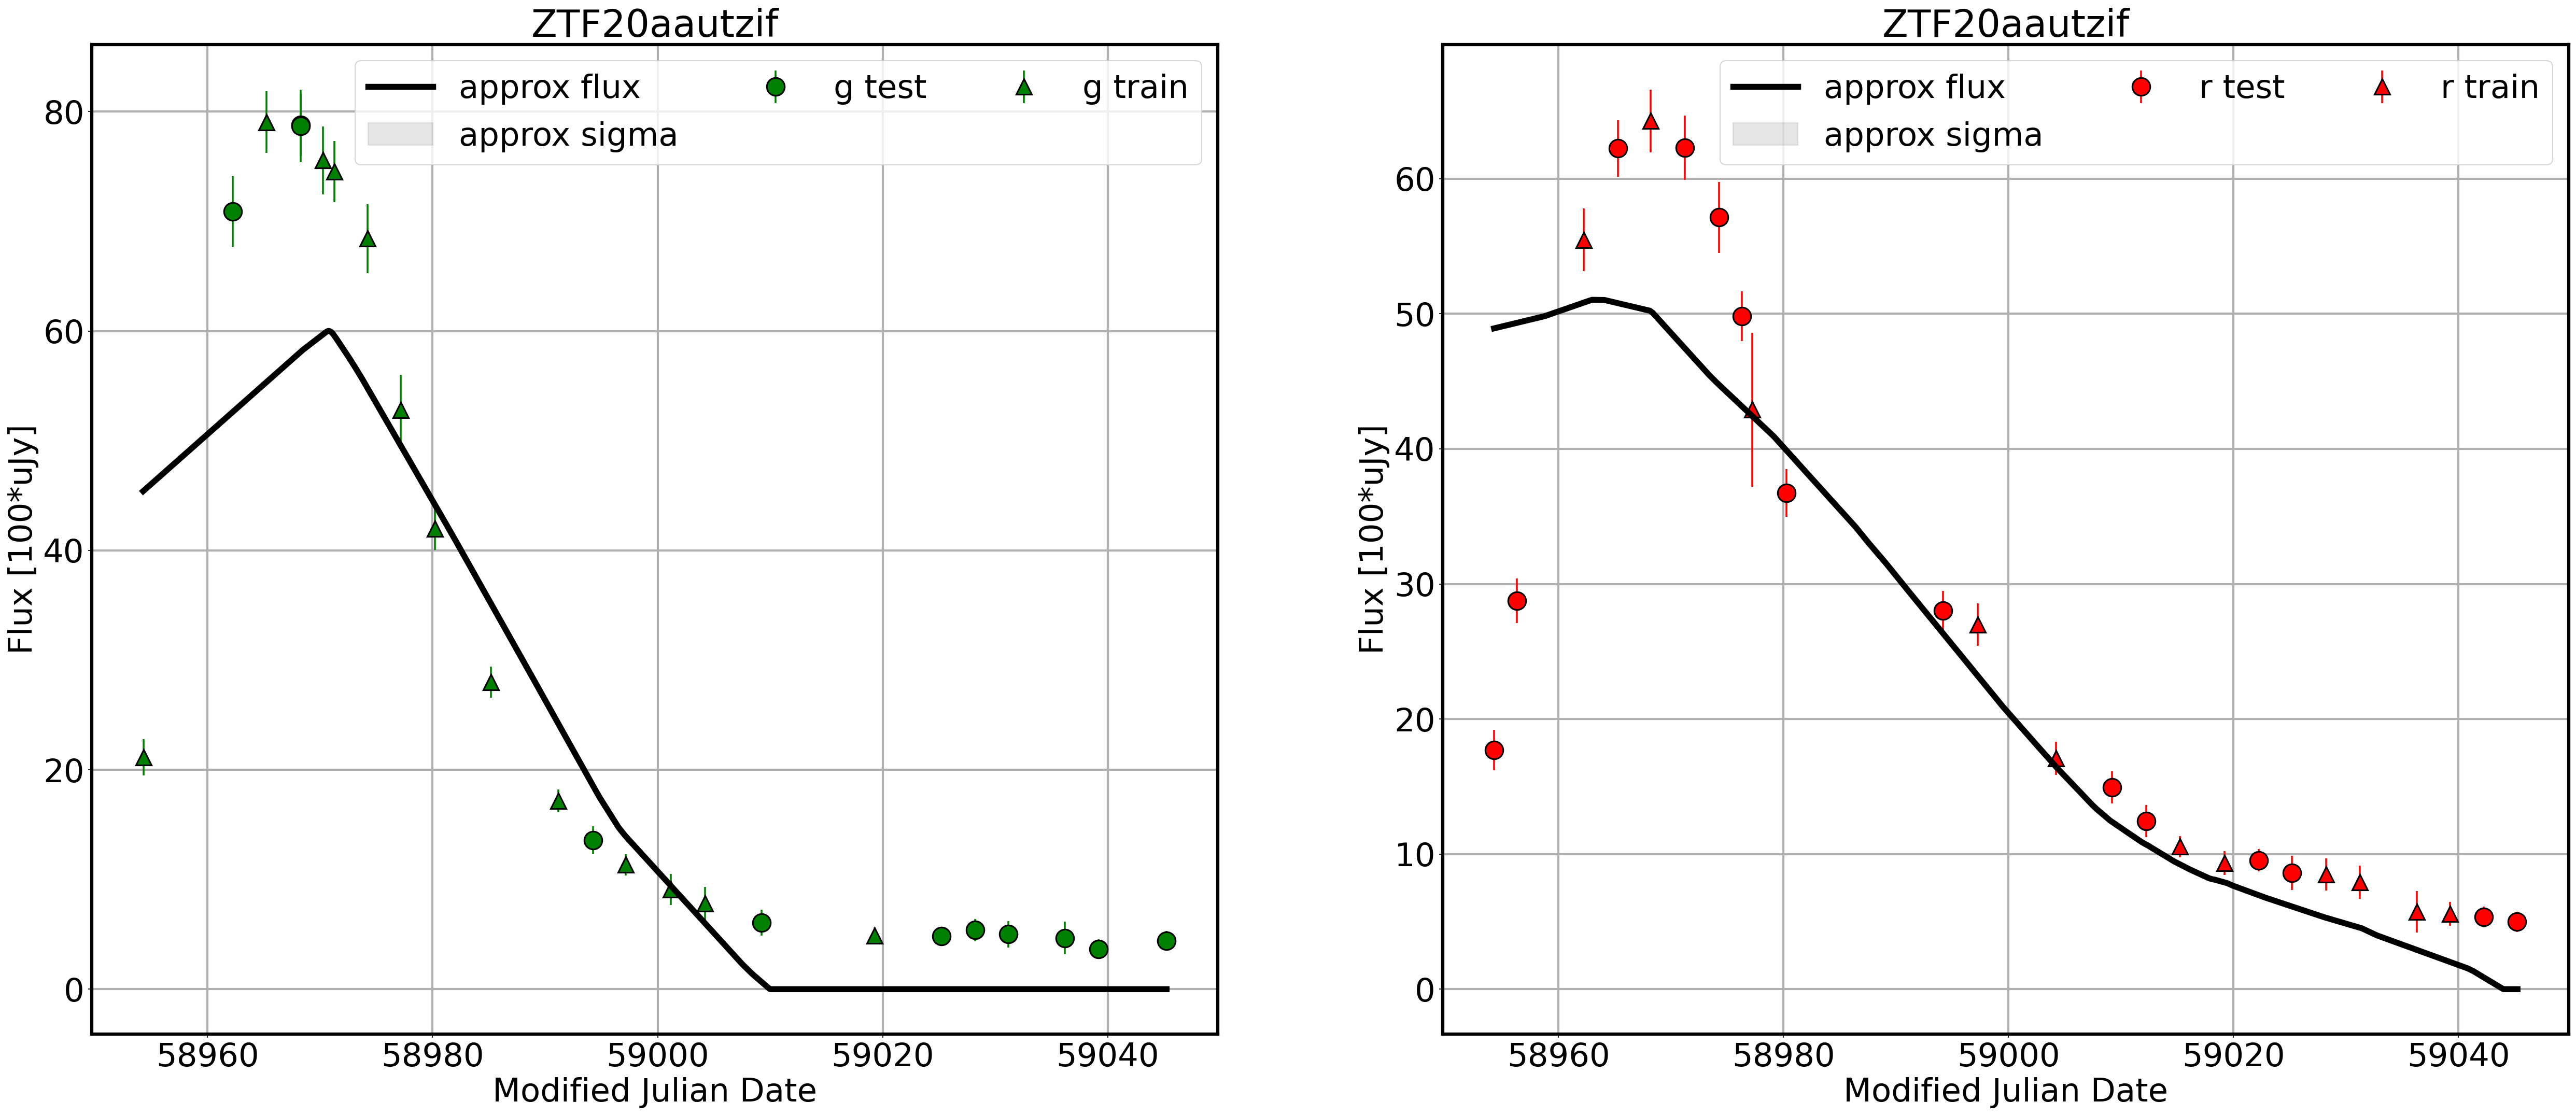

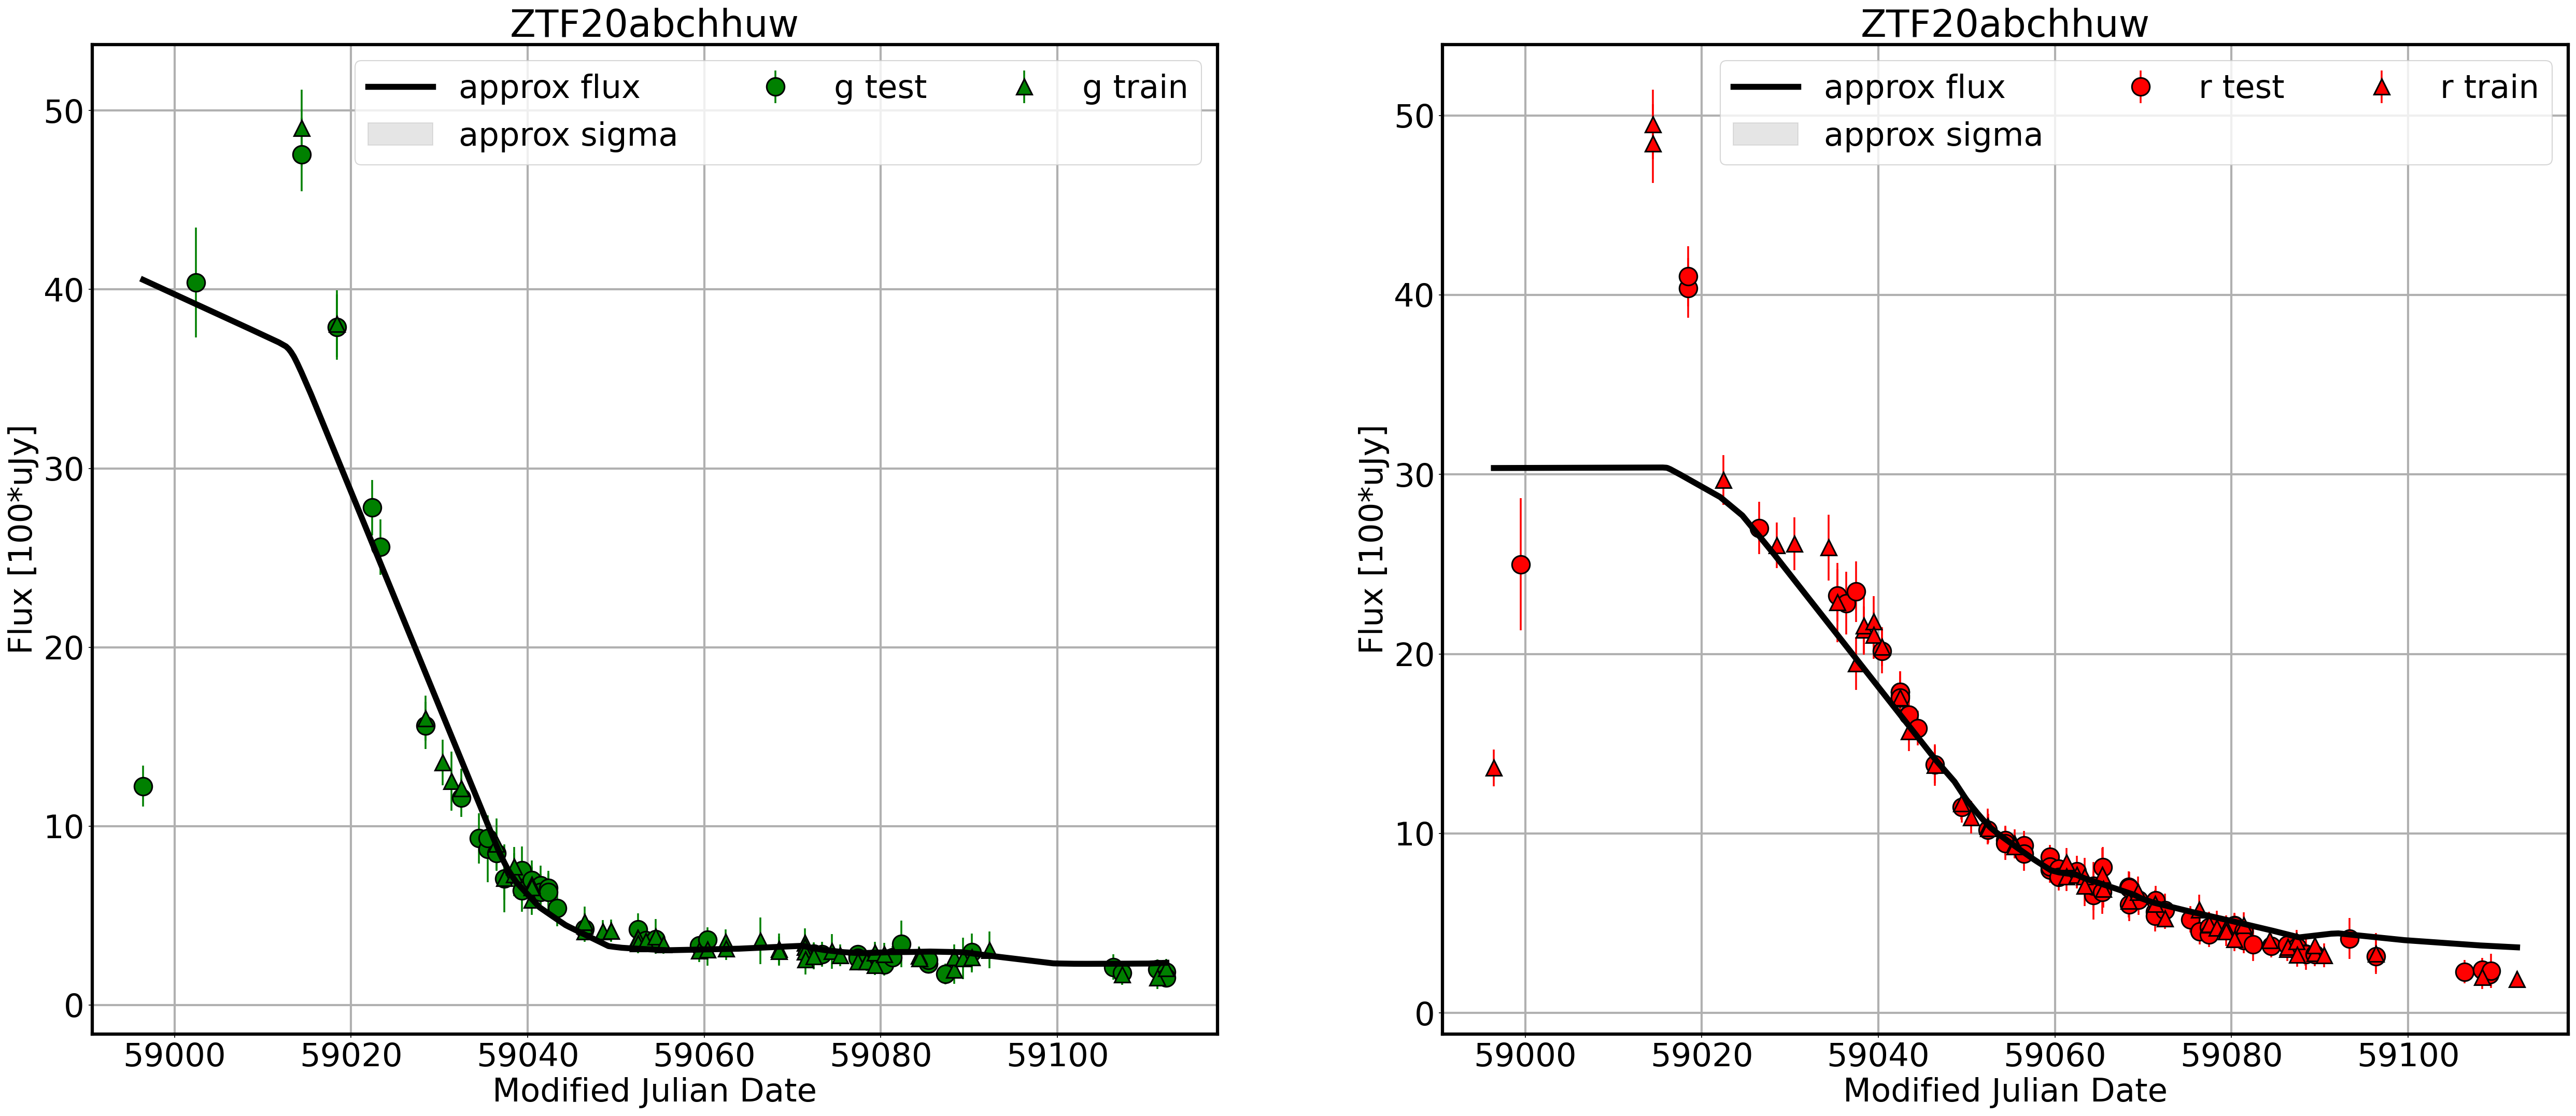

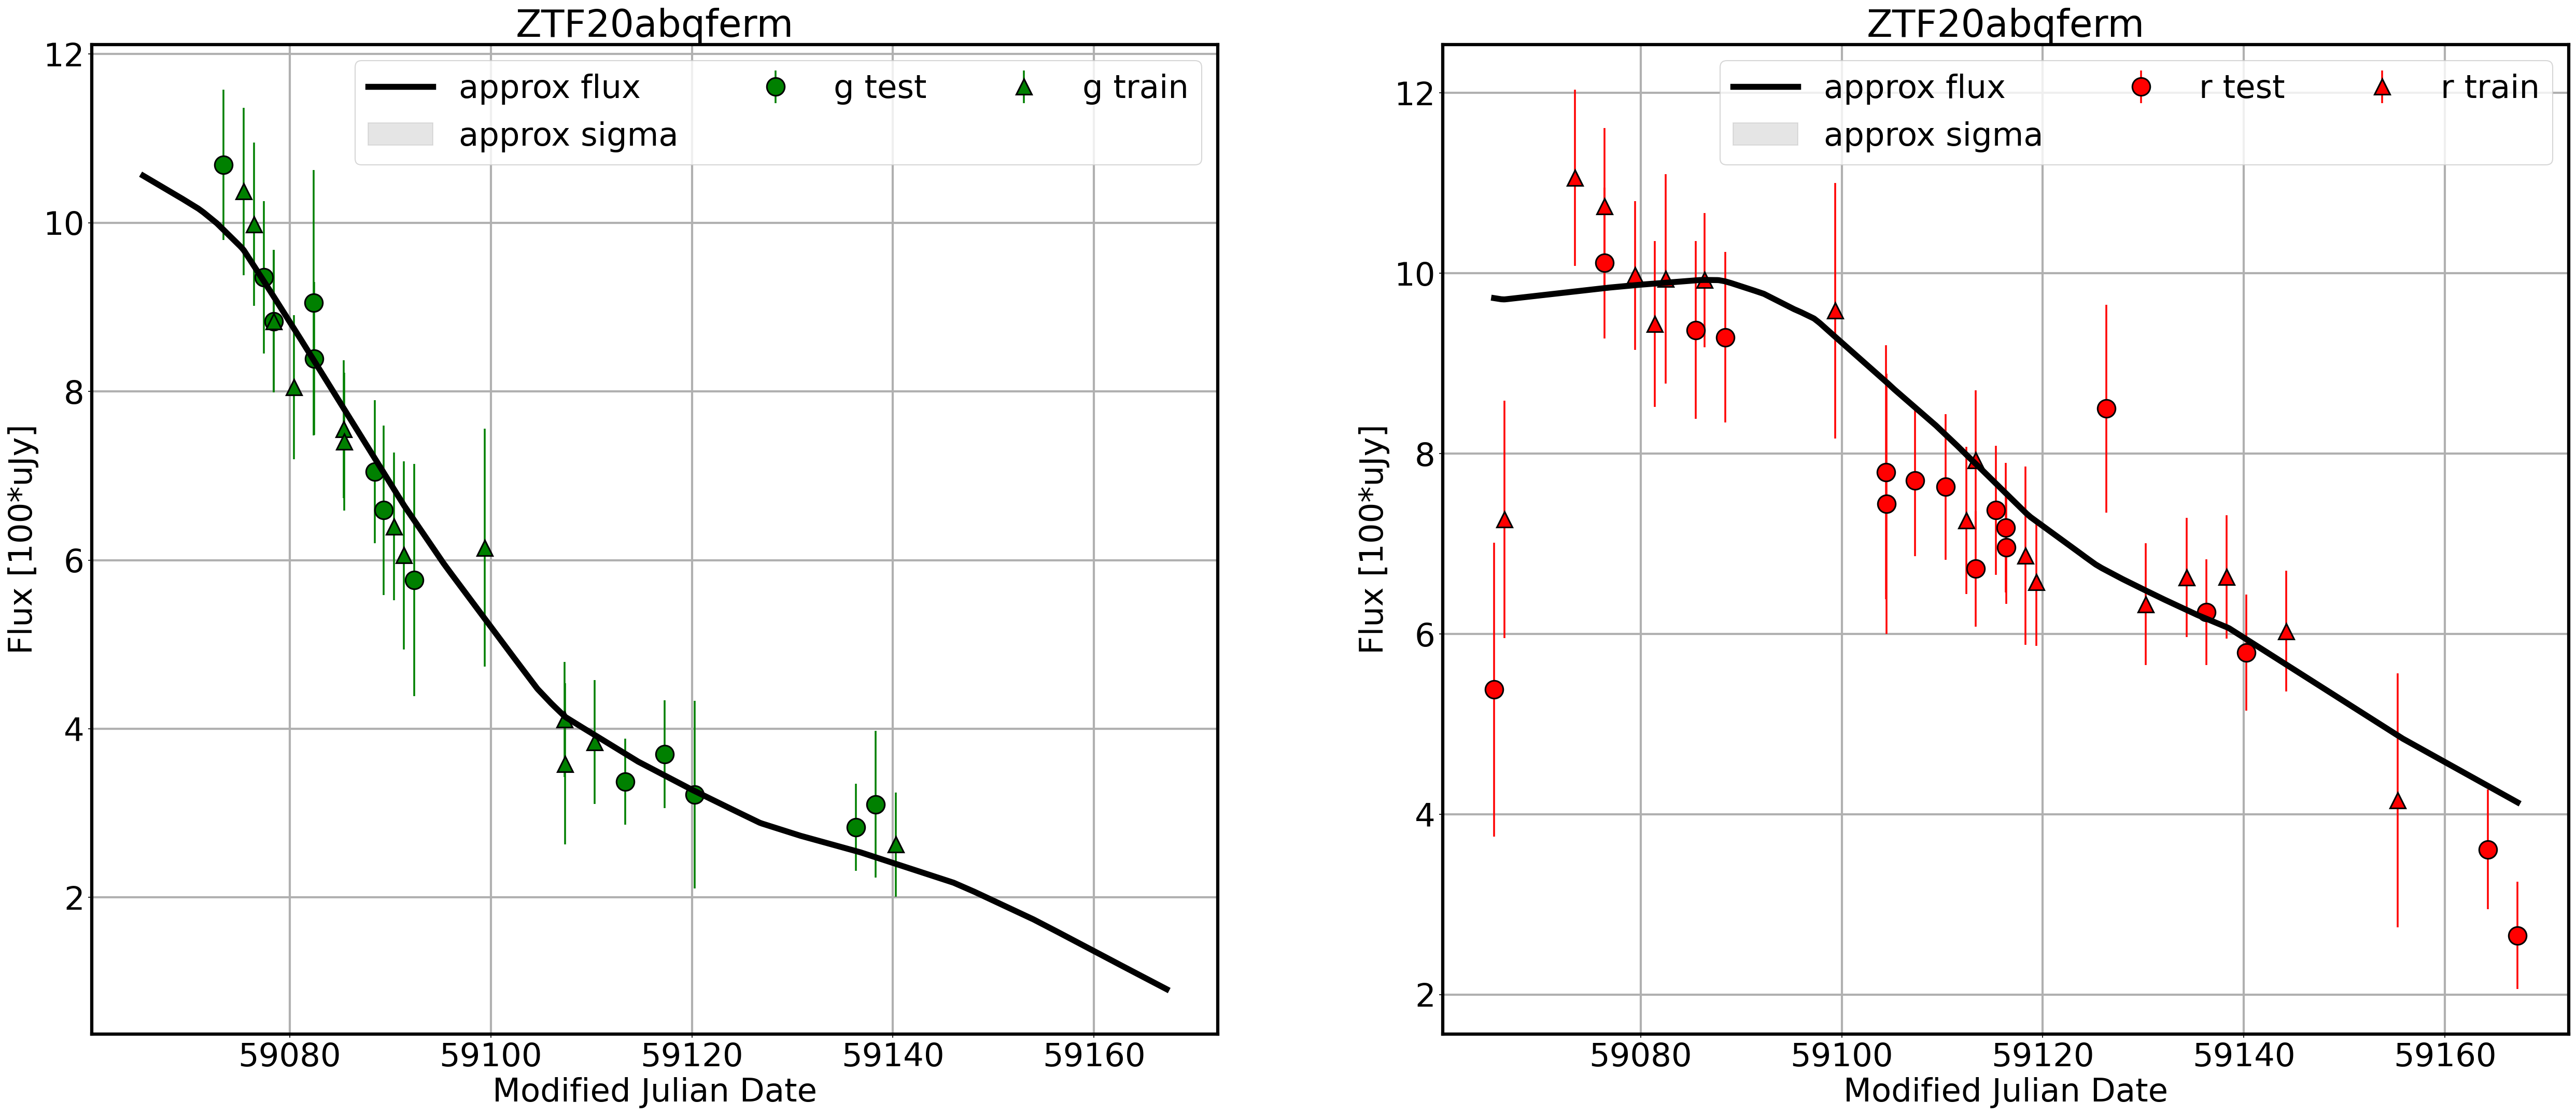

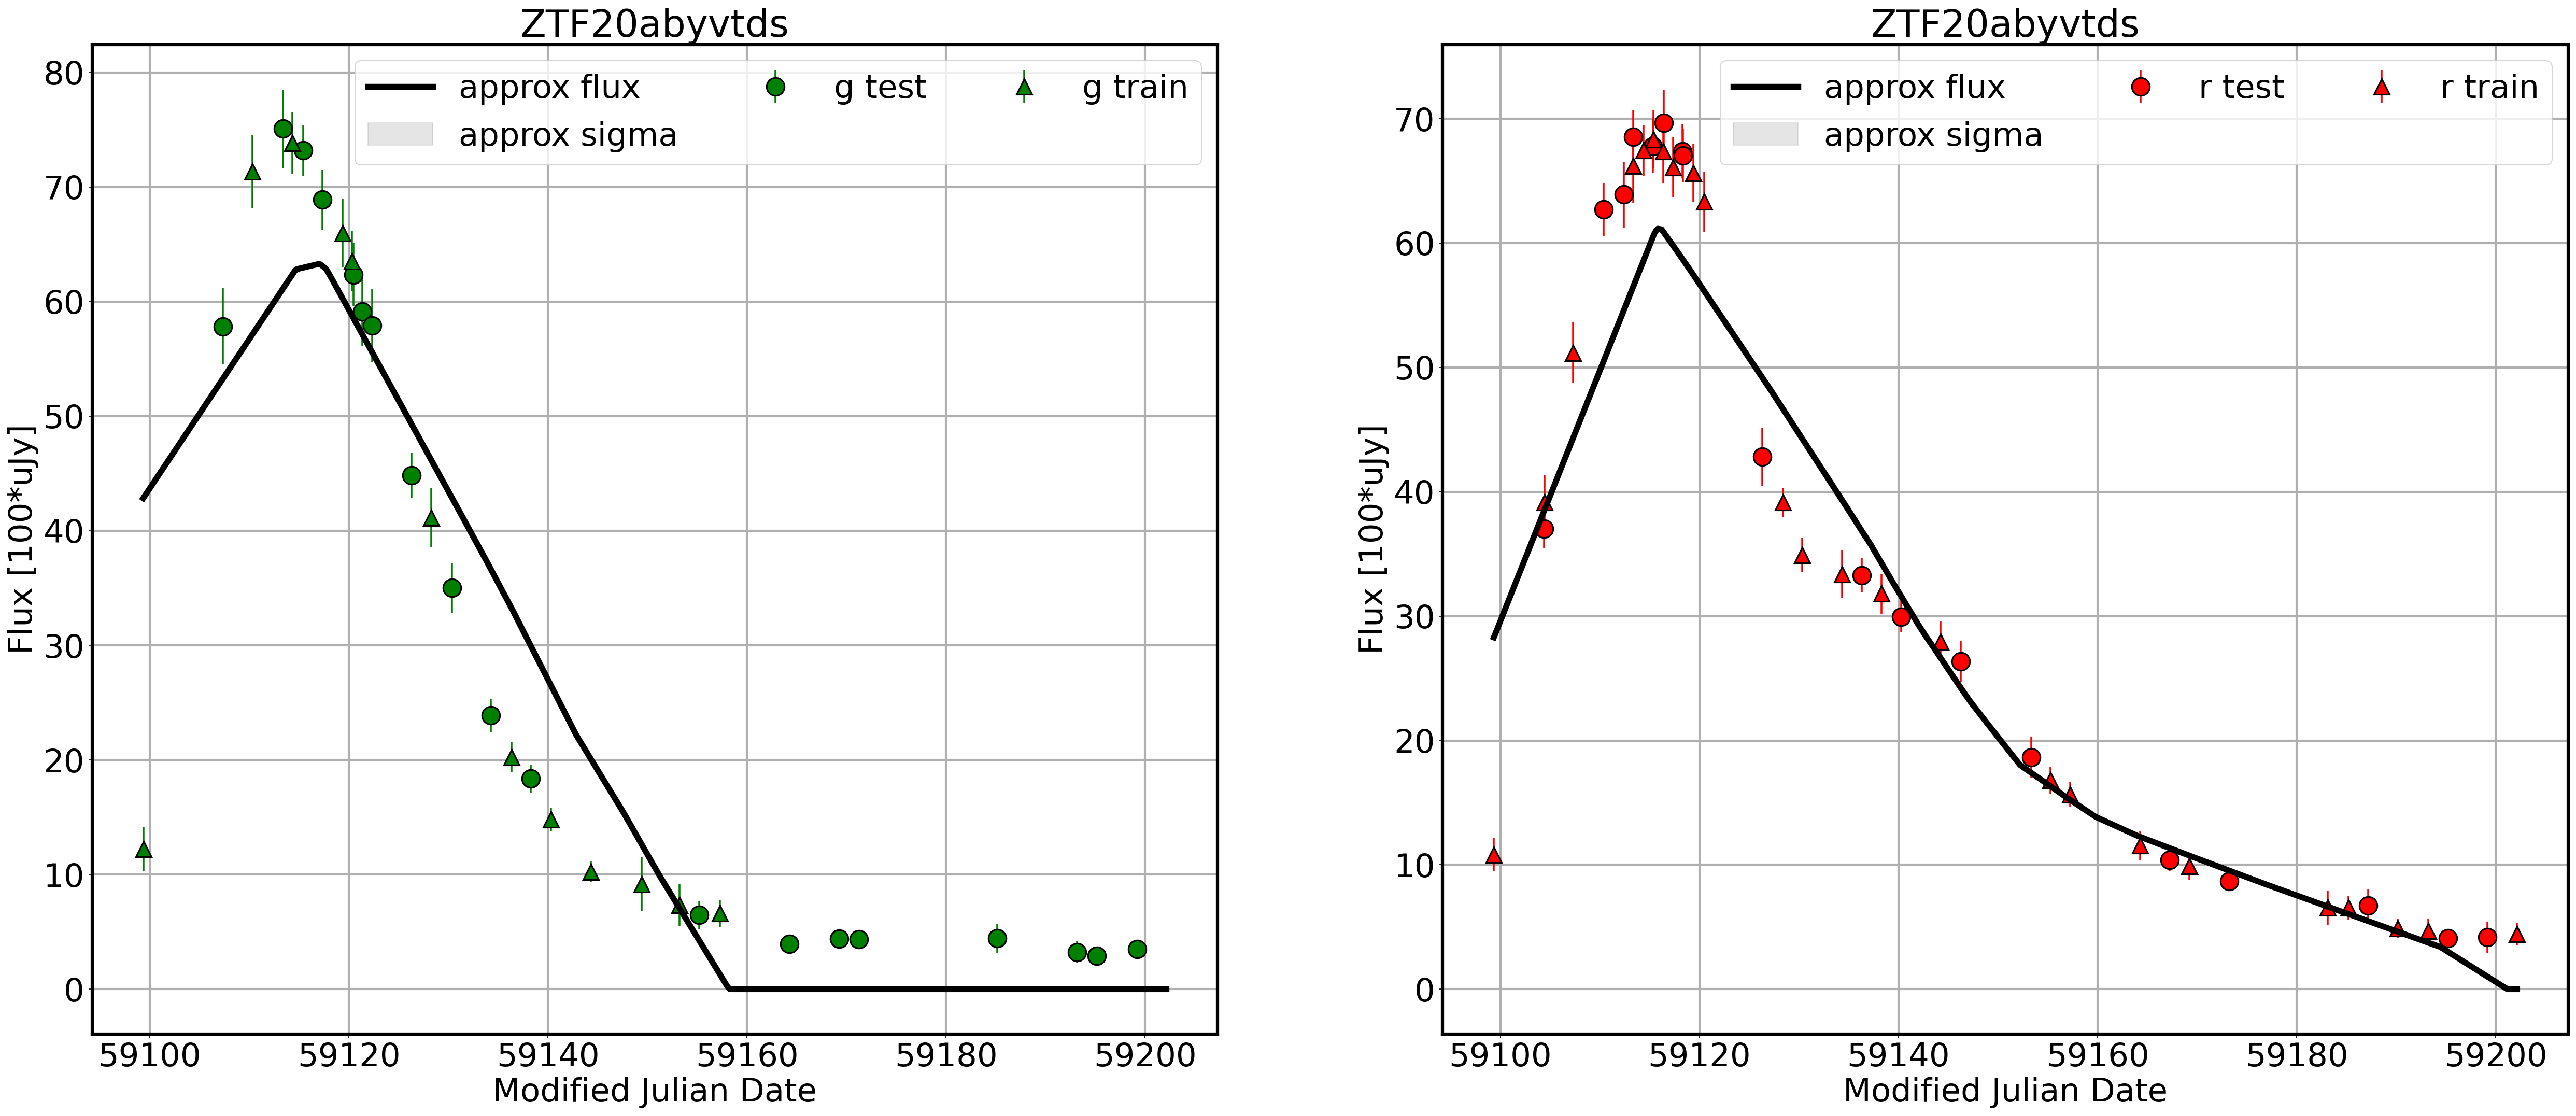

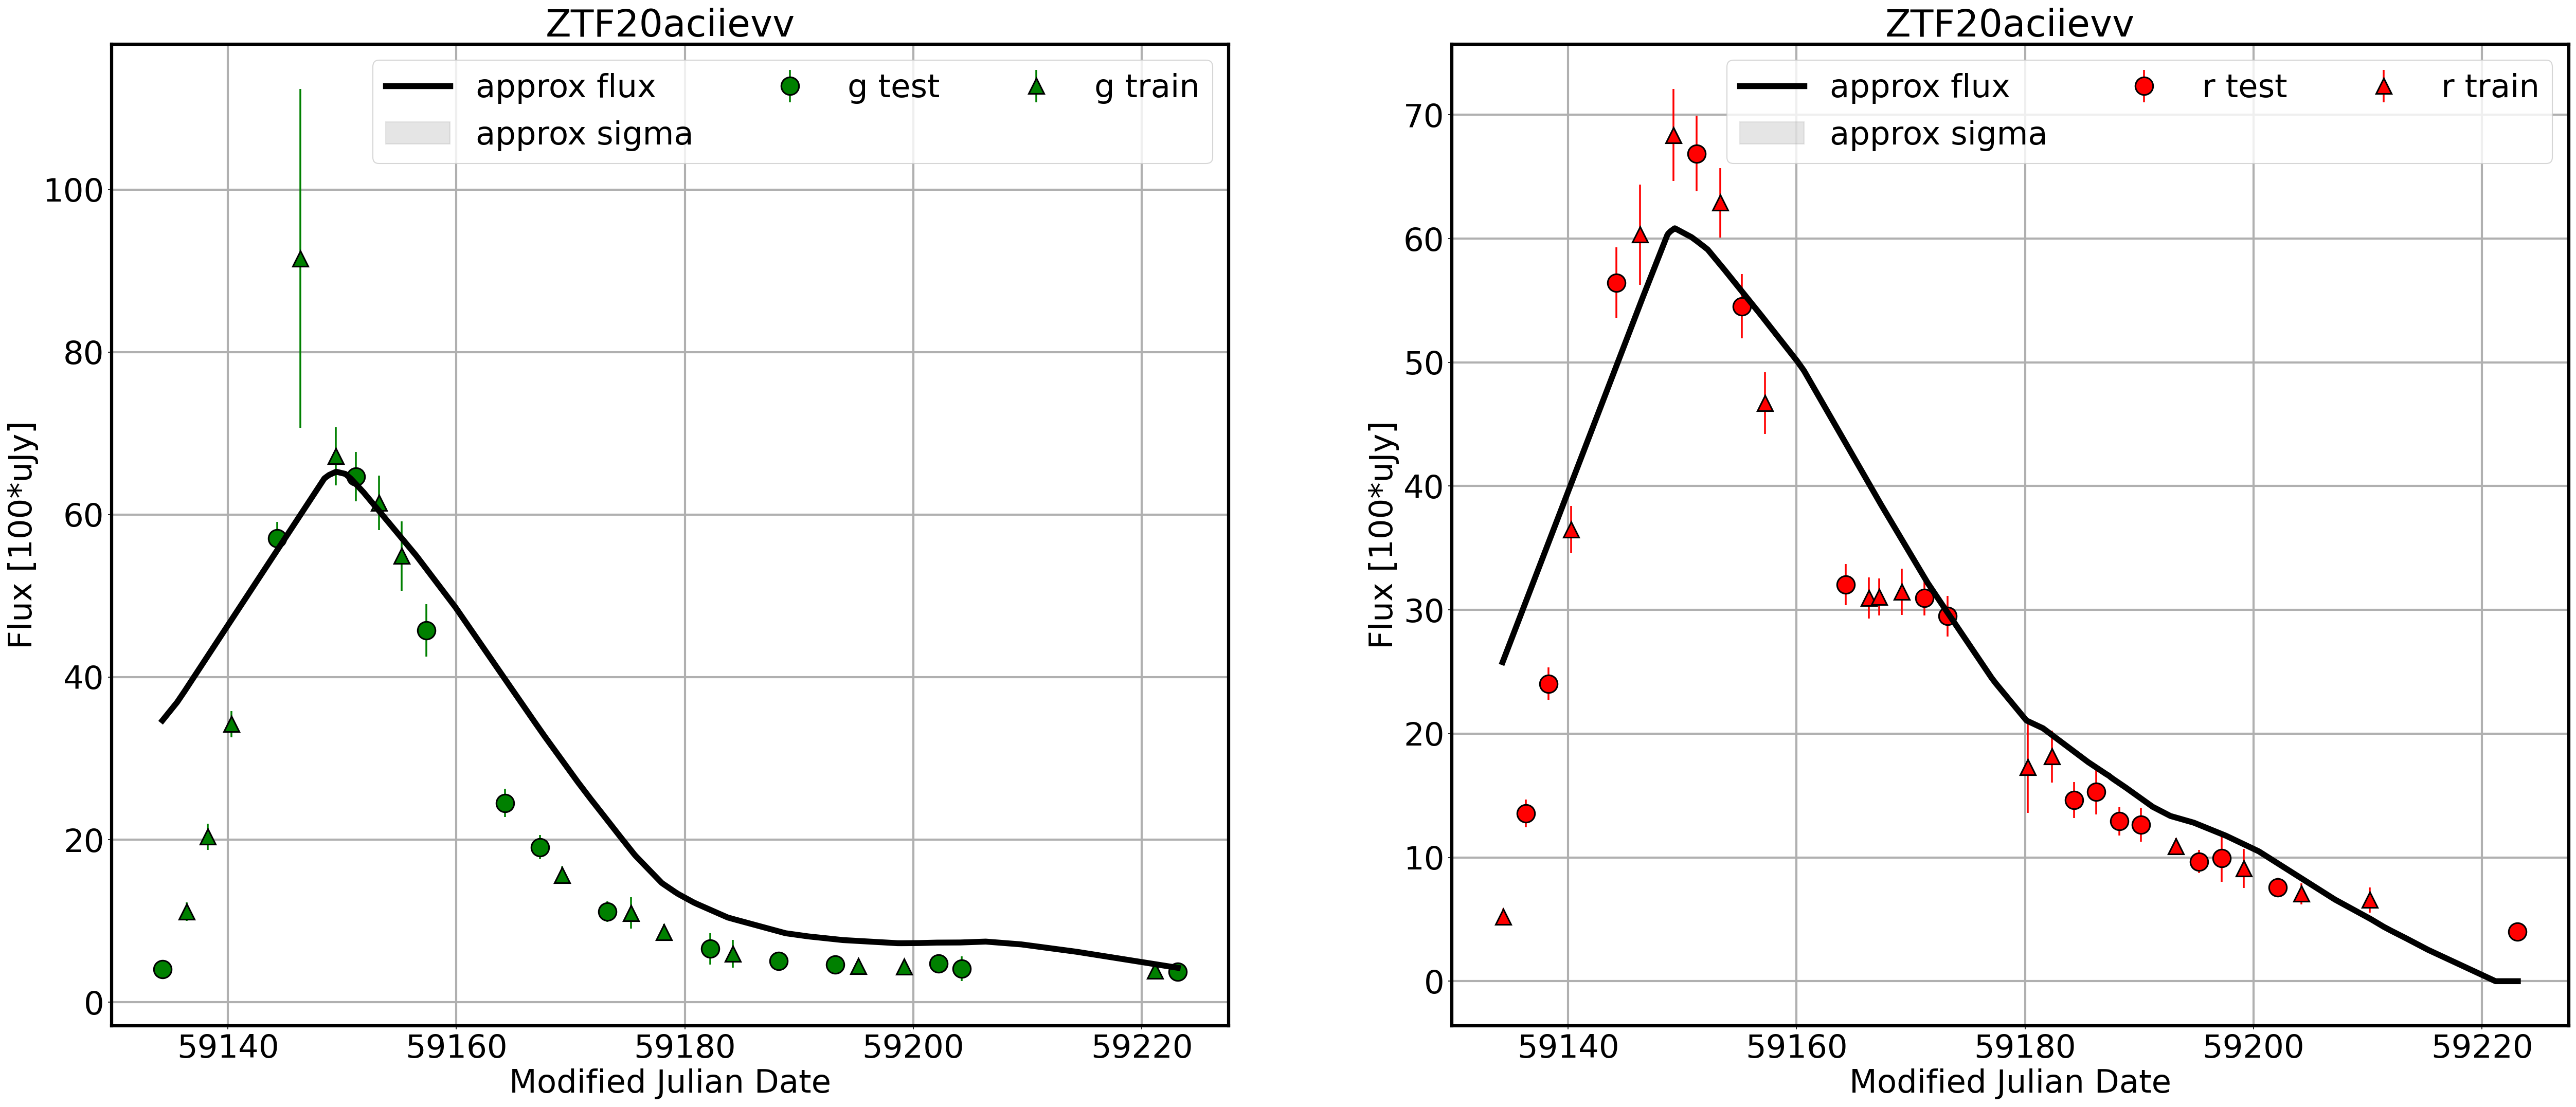

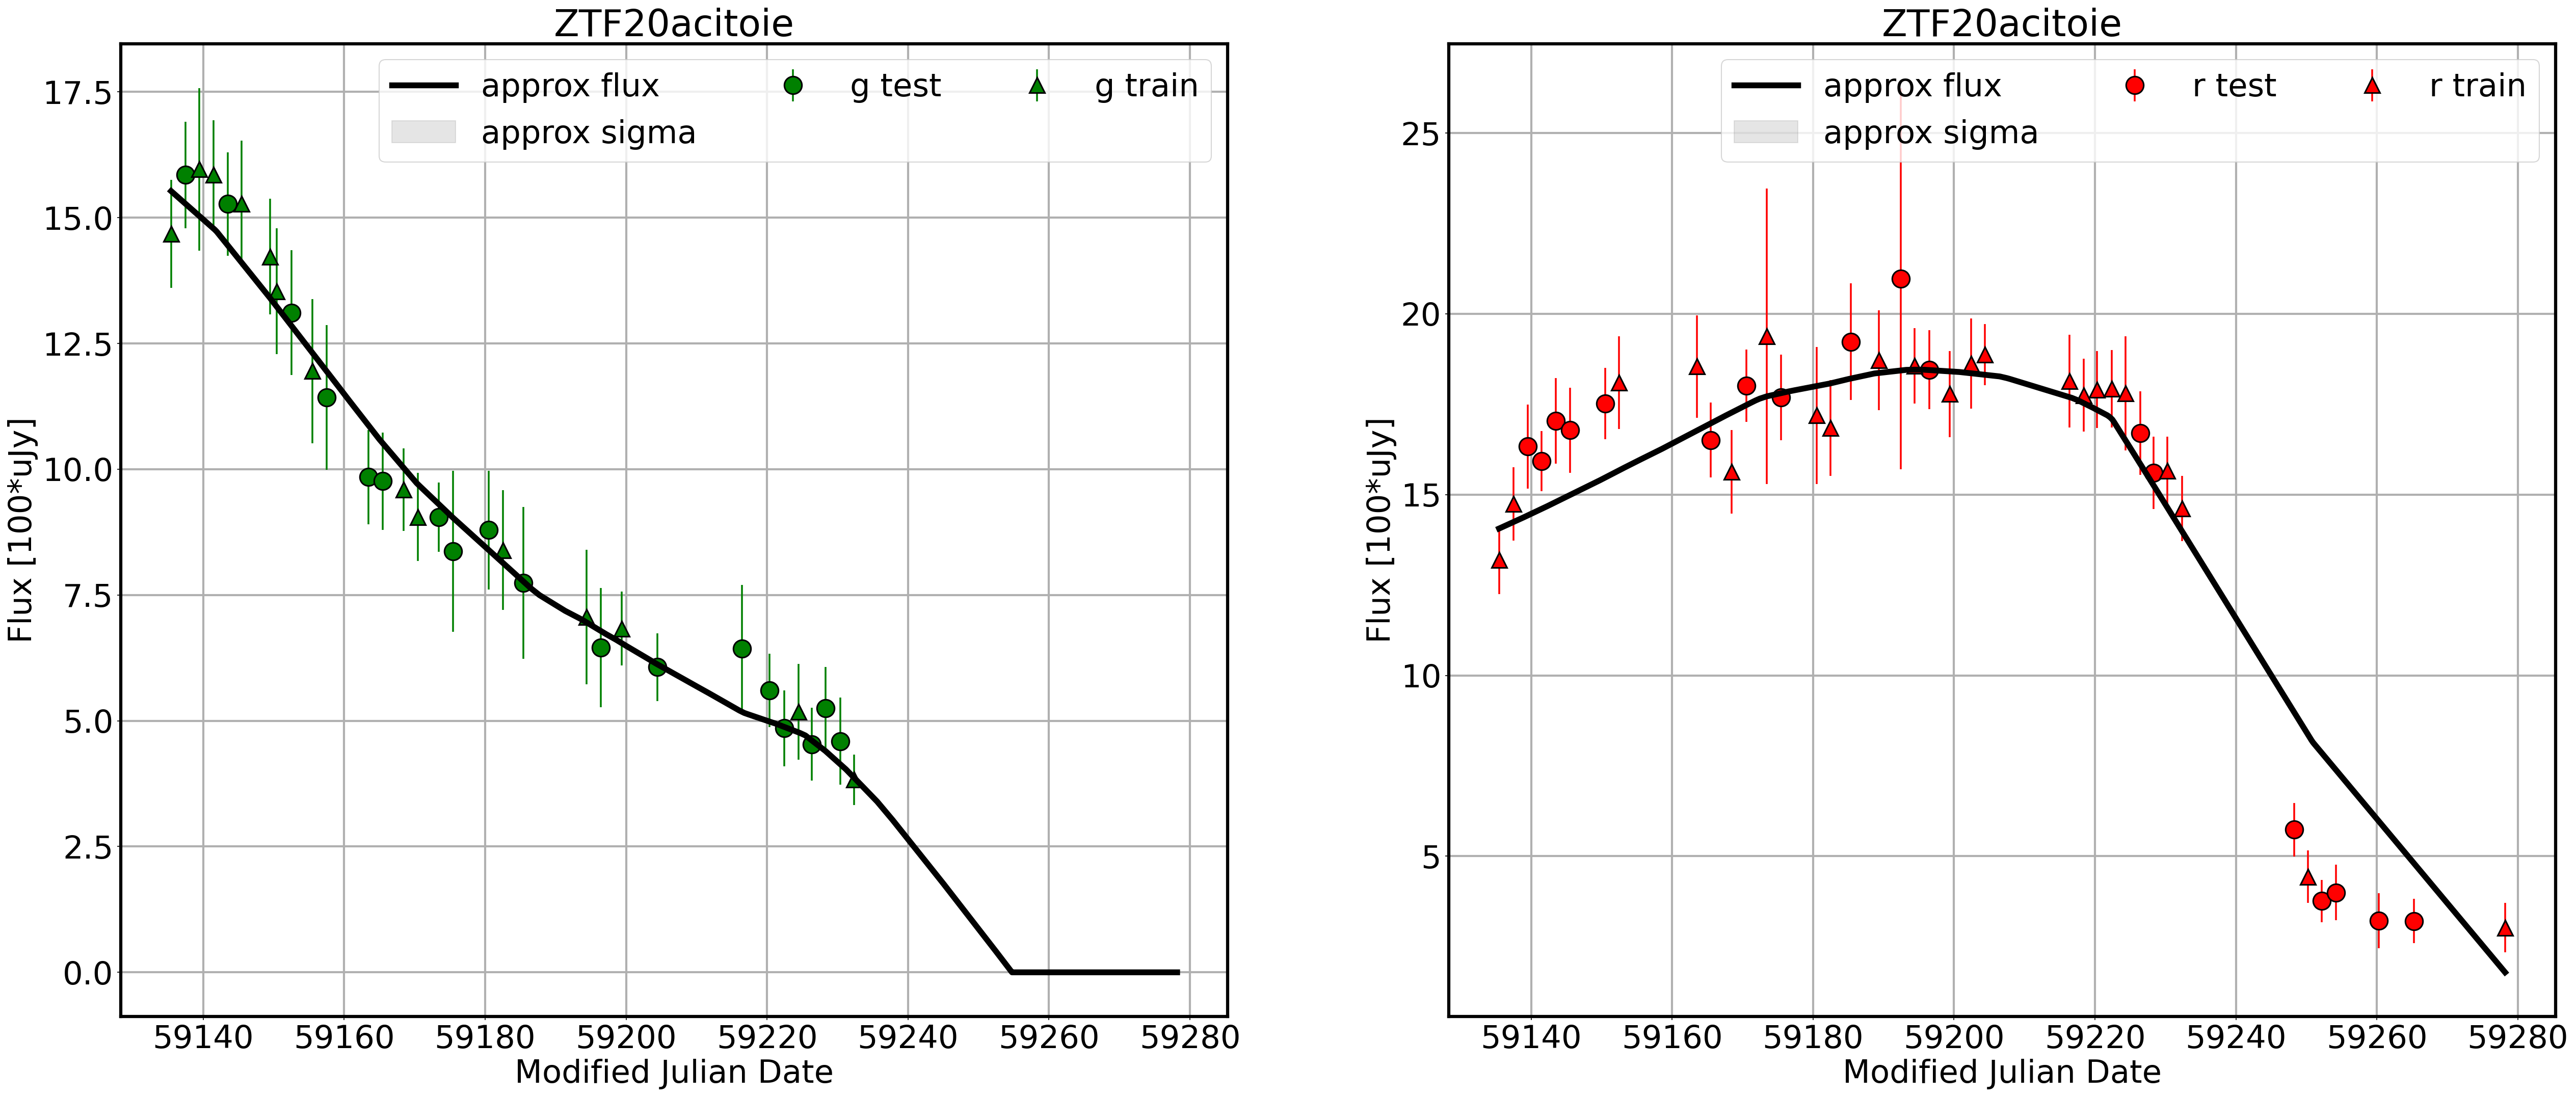

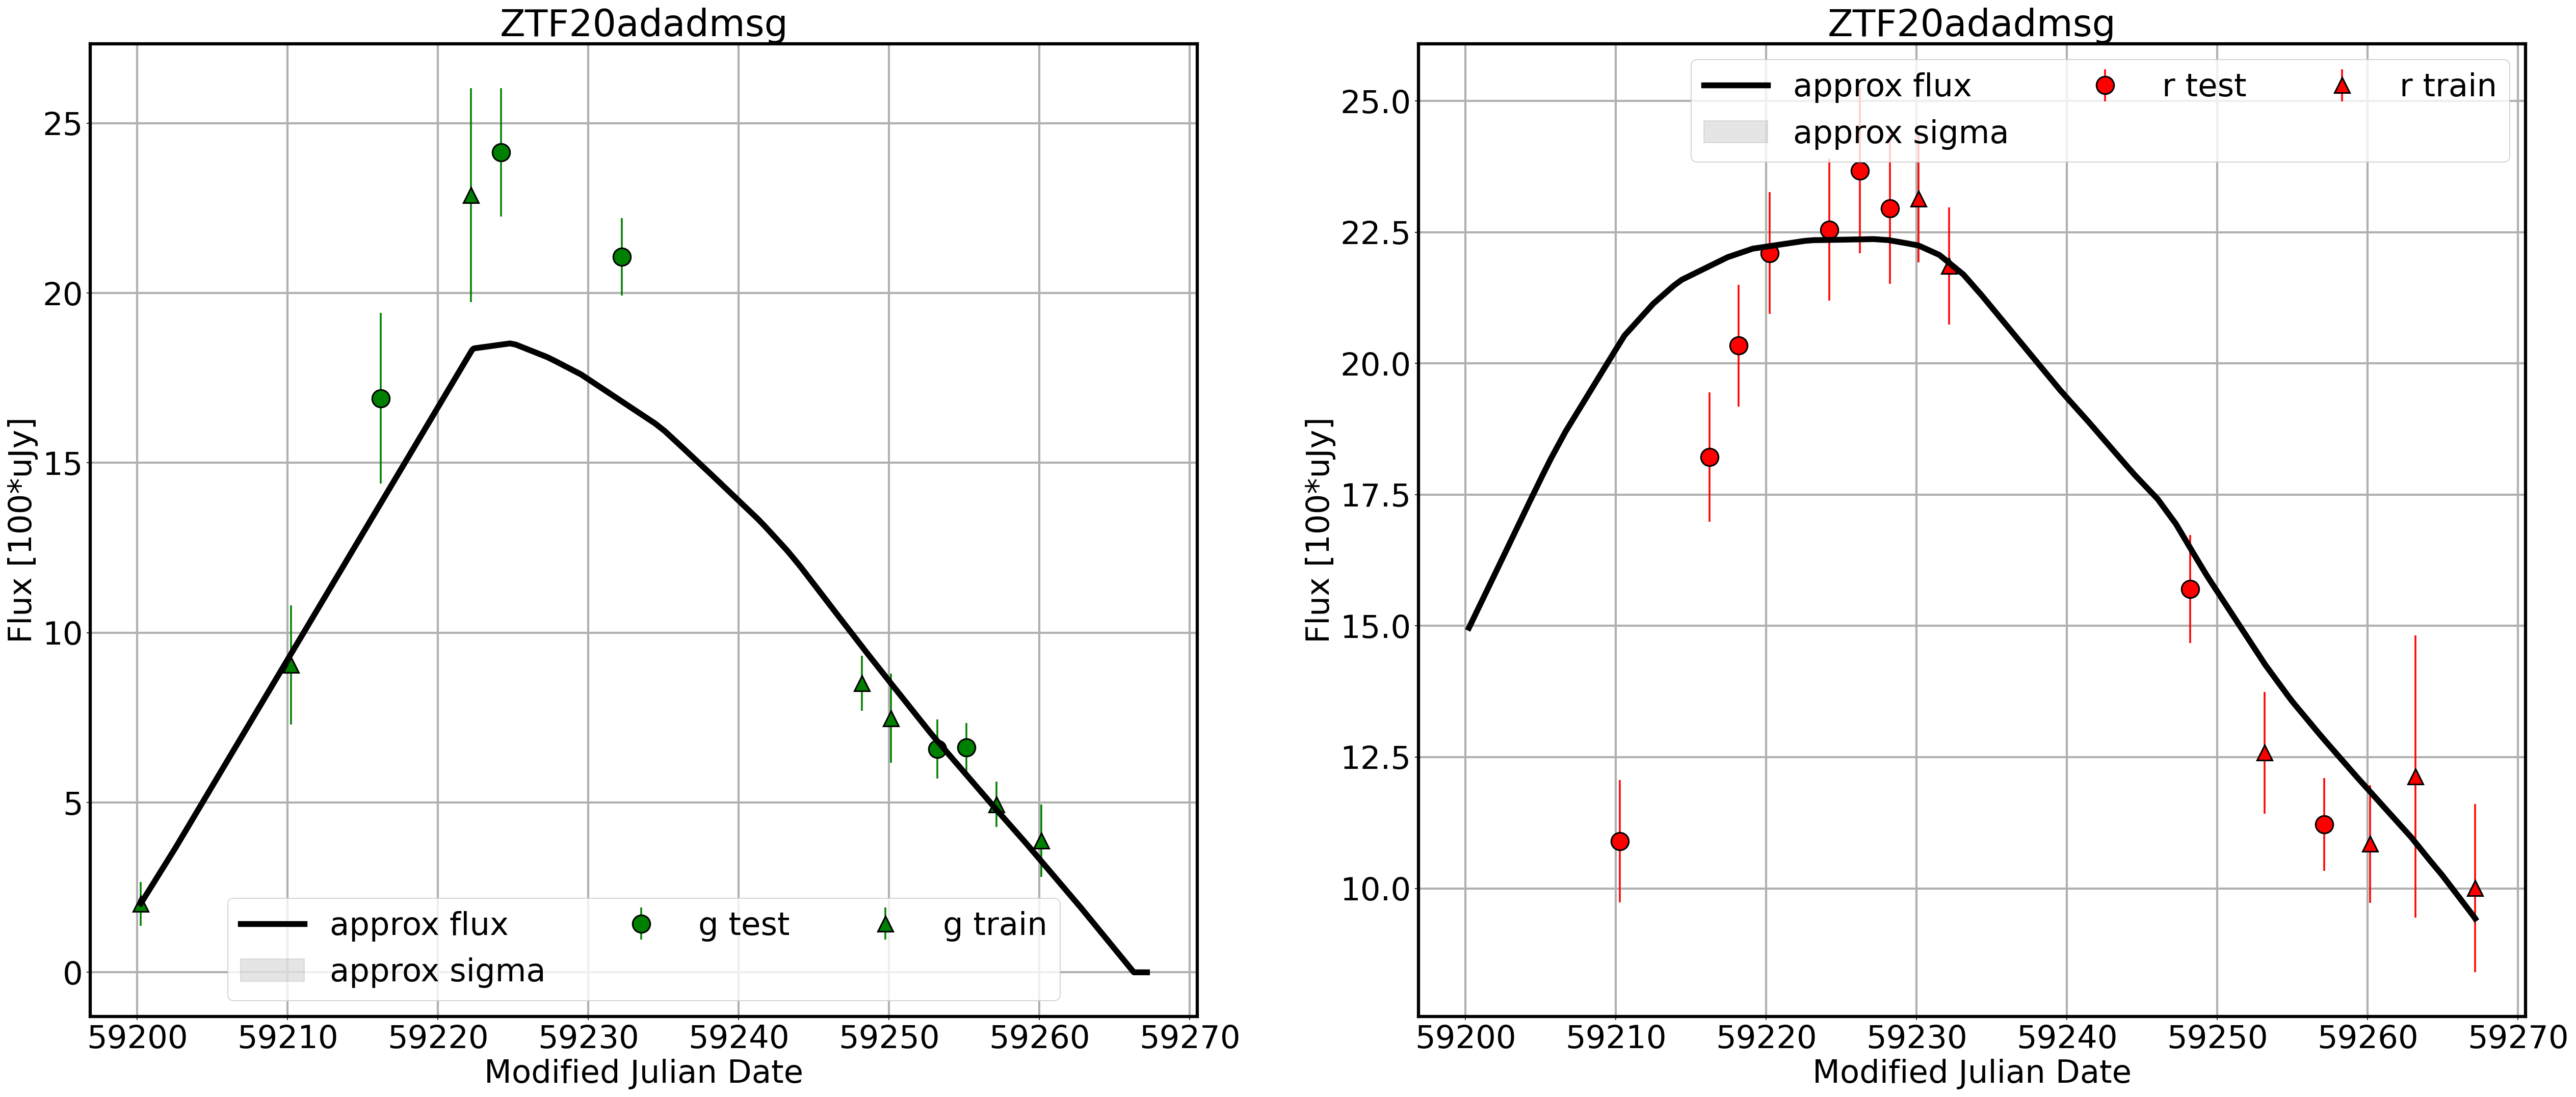

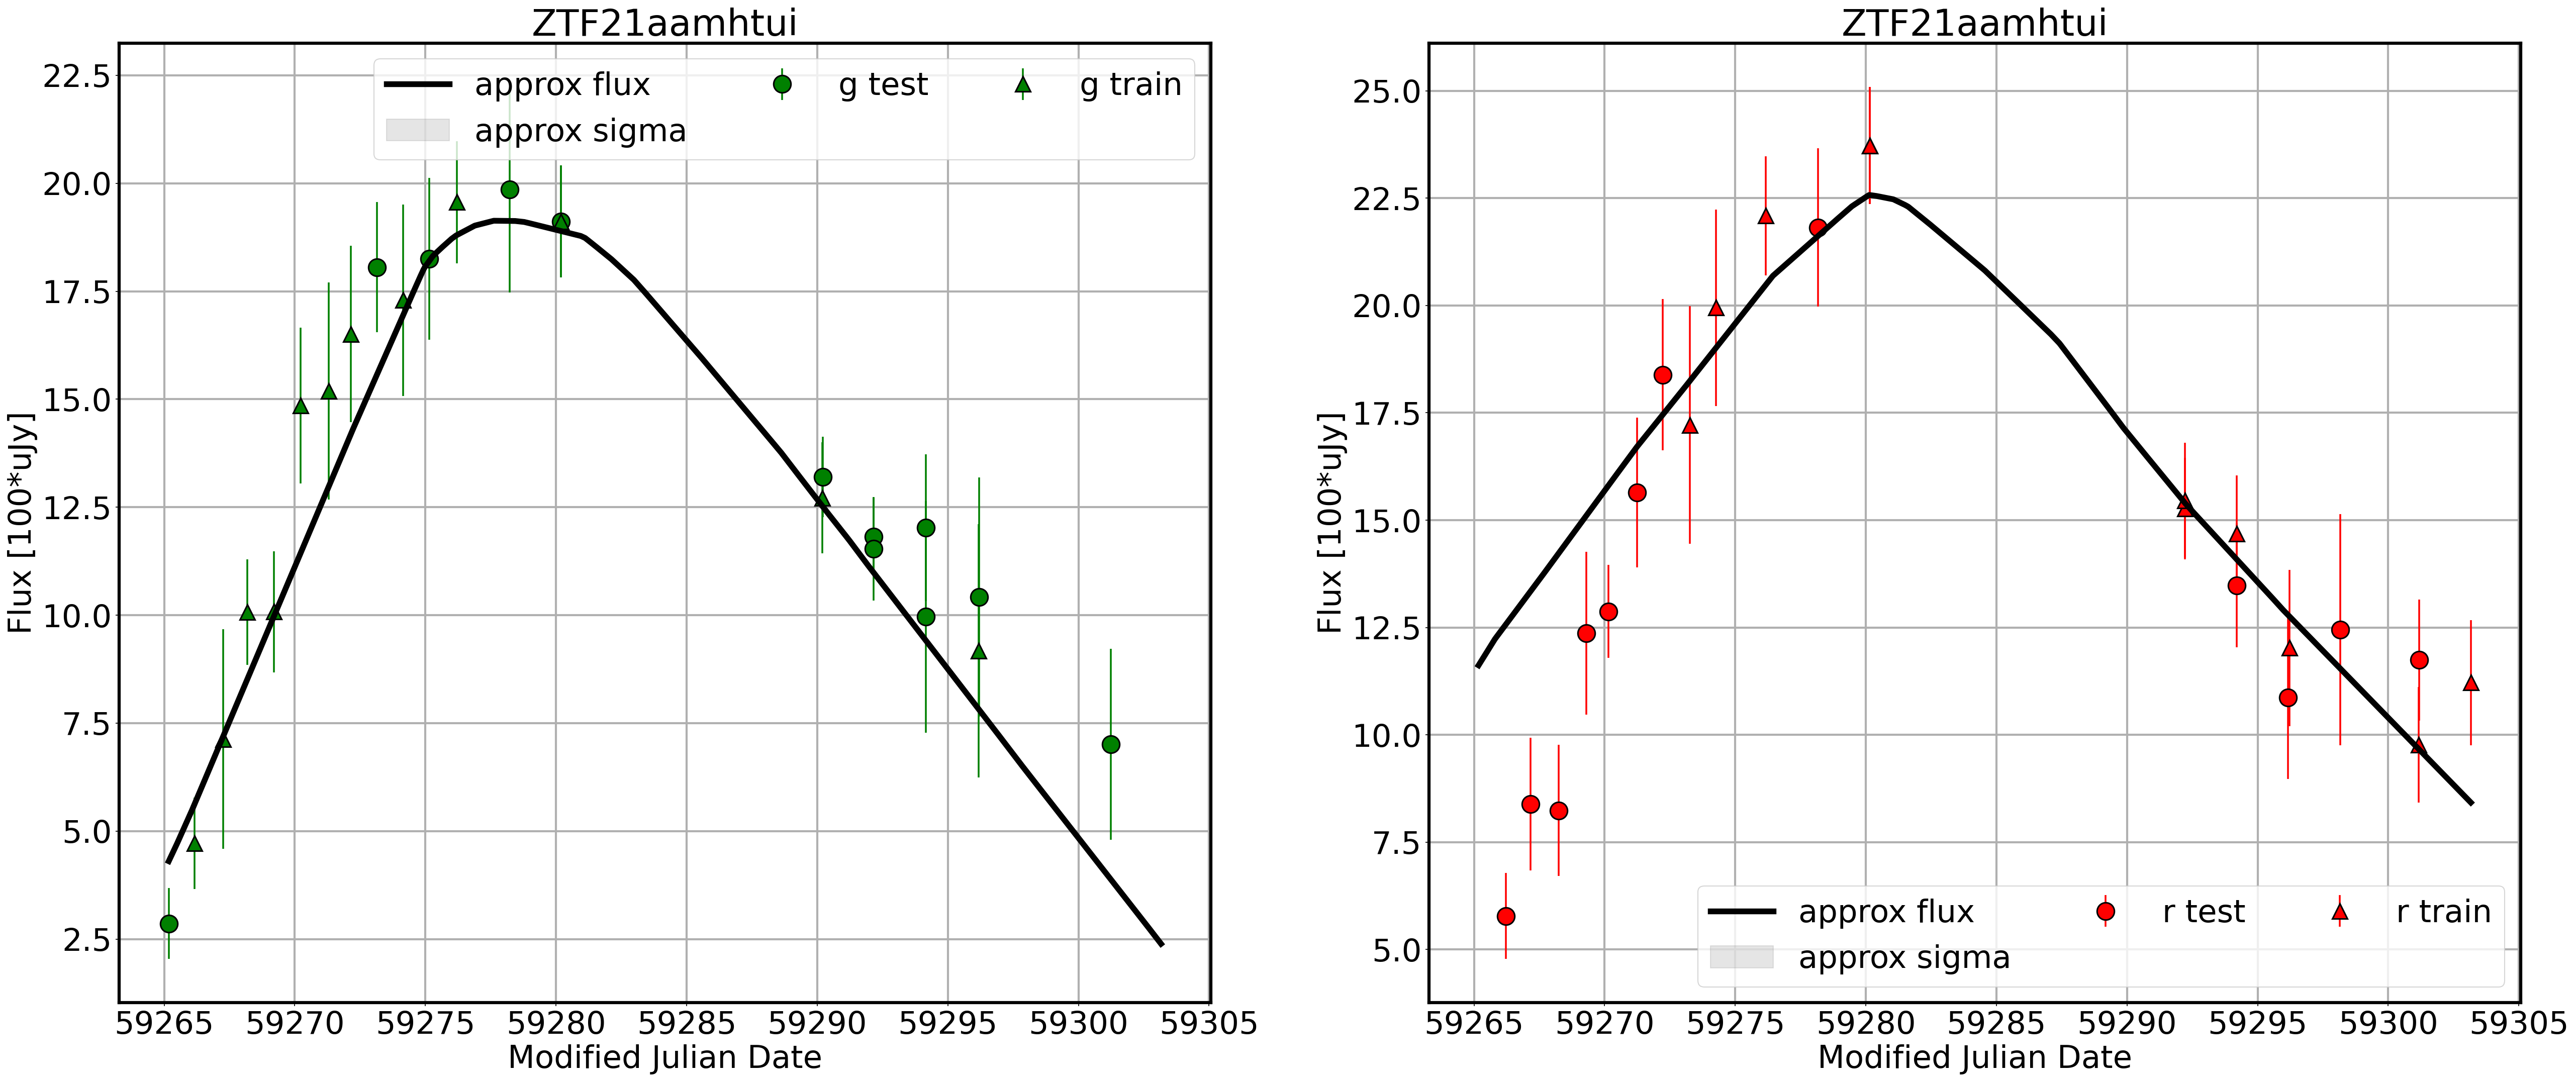

In [80]:
report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])


for name, i in tqdm(zip(df_all['object_id'].unique()[::100], range(len(df_all['object_id'].unique()[::100])))):
    fig = plt.figure(figsize=(35,35), dpi = 150)
    plt.rcParams.update({'font.size': 30})
    fig.subplots_adjust(left=0.07, right=0.98, top=0.95, bottom=0.15)
    ax1 = plt.subplot(2, 2, 1)
    ax2 = plt.subplot(2, 2, 2)

    ax1.spines['bottom'].set_linewidth(3)
    ax1.spines['top'].set_linewidth(3)
    ax1.spines['left'].set_linewidth(3)
    ax1.spines['right'].set_linewidth(3)
    
    ax2.spines['bottom'].set_linewidth(3)
    ax2.spines['top'].set_linewidth(3)
    ax2.spines['left'].set_linewidth(3)
    ax2.spines['right'].set_linewidth(3)
    
    #anobject = get_object(data, name)
#     if not is_good(anobject):
#         continue

    
    # fit augmentation model
    anobject = aug_standart_ztf.get_object(df_all, name)
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)
    
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
          anobject_train['flux_err'].values, anobject_train['passband'].values)

    # predict flux for unseen observations
    flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values)

    # augmentation
    t_aug, flux_aug, flux_err_aug, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                                  anobject['mjd'].max(), 
                                                                  n_obs=N_OBS)
    anobject_test_pred = anobject_test.copy()
    anobject_test_pred['flux'], anobject_test_pred['flux_err'] = flux_pred, flux_err_pred
    
    anobject_aug = aug_standart_ztf.compile_obj(t_aug, flux_aug, flux_err_aug, passbands_aug)
    
    metrics = utils.regression_quality_metrics_report(anobject_test['flux'].values, flux_pred)
    report.loc[len(report), :] = [i] + list(metrics)
    
    aug_standart_ztf.plot_light_curves_ax_band(anobject_test, anobject_train, anobject_aug, ax1, ax2, name)
    ax1.legend(loc='best', ncol=3, fontsize=30)
    ax2.legend(loc='best', ncol=3, fontsize=30)

for i in report.columns[1:].values:
    mean, std = bootstrap_estimate_mean_stddev(report[i].values)
    print('Среднее значение метрики ' + i + ' {}'.format(mean), 
          "+-", std)

In [81]:
report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])


for name, i in tqdm(zip(df_all['object_id'].unique(), range(len(df_all['object_id'].unique())))):

    # fit augmentation model
    anobject = aug_standart_ztf.get_object(df_all, name)
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)
    
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
          anobject_train['flux_err'].values, anobject_train['passband'].values)

    # predict flux for unseen observations
    flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values)

    # augmentation
    t_aug, flux_aug, flux_err_aug, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                                  anobject['mjd'].max(), 
                                                                  n_obs=N_OBS)
    anobject_test_pred = anobject_test.copy()
    anobject_test_pred['flux'], anobject_test_pred['flux_err'] = flux_pred, flux_err_pred
    
    anobject_aug = aug_standart_ztf.compile_obj(t_aug, flux_aug, flux_err_aug, passbands_aug)
    
    metrics = utils.regression_quality_metrics_report(anobject_test['flux'].values, flux_pred)
    report.loc[len(report), :] = [i] + list(metrics)
    


for i in report.columns[1:].values:
    mean, std = bootstrap_estimate_mean_stddev(report[i].values)
    print('Среднее значение метрики ' + i + ' {}'.format(mean), 
          "+-", std)

1403it [13:08,  1.78it/s]


Среднее значение метрики RMSE 6.295473419182437 +- 0.5559564707635979
Среднее значение метрики MAE 4.208798909356185 +- 0.33481608364355214
Среднее значение метрики RSE 0.5364874523709082 +- 0.007953926400634097
Среднее значение метрики RAE 0.4619470547173608 +- 0.007291132222173899
Среднее значение метрики MAPE 24.31818506574352 +- 0.698902285421849
